In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Plotting style
plt.style.use('fivethirtyeight')
%matplotlib inline

## 1. User Configuration
Adjust these parameters to customize the scanner for your needs.

In [2]:
# --- Configuration & Data Fetching ---

# Global dictionary to map Ticker -> Sector
TICKER_SECTORS = {}

# Map Sector Names to their ETF Proxies
SECTOR_ETF_MAP = {
    'Energy': 'XLE',
    'Information Technology': 'XLK',
    'Technology': 'XLK',
    'Communication Services': 'XLC',
    'Consumer Discretionary': 'XLY',
    'Consumer Staples': 'XLP',
    'Financials': 'XLF',
    'Financial Services': 'XLF',
    'Health Care': 'XLV',
    'Industrials': 'XLI',
    'Materials': 'XLB',
    'Basic Materials': 'XLB',
    'Real Estate': 'XLRE',
    'Utilities': 'XLU'
}

def get_sp500_tickers_and_sectors():
    """Scrapes Symbol and Sector from Wikipedia"""
    try:
        import requests
        import io
        url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers)
        df = pd.read_html(io.StringIO(response.text))[0]
        
        # Populate the global map
        for index, row in df.iterrows():
            sym = row['Symbol'].replace('.', '-')
            sector = row['GICS Sector']
            TICKER_SECTORS[sym] = sector
            
        return list(TICKER_SECTORS.keys())
    except Exception as e:
        print(f"Error fetching S&P 500: {e}")
        return ['SPY', 'AAPL', 'MSFT']

def get_tsx_tickers_and_sectors():
    """Scrapes Symbol and Sector from Wikipedia for TSX"""
    try:
        import requests
        import io
        url = 'https://en.wikipedia.org/wiki/S%26P/TSX_Composite_Index'
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers)
        
        # Find table with 'Ticker' column
        tables = pd.read_html(io.StringIO(response.text))
        df = next(t for t in tables if 'Ticker' in t.columns)
        
        tickers = []
        for index, row in df.iterrows():
            sym = str(row['Ticker']).replace('.', '-') + ".TO"
            
            # TSX Wikipedia often has a 'Sector' column
            if 'Sector' in row:
                TICKER_SECTORS[sym] = row['Sector']
            else:
                TICKER_SECTORS[sym] = 'Canadian Market'
                
            tickers.append(sym)

        return tickers

    except Exception as e:
        print(f"Error fetching TSX list: {e}")
        return ['SHOP.TO', 'RY.TO', 'TD.TO']

# Load Both Lists
print("Fetching tickers and sectors...")
sp500 = get_sp500_tickers_and_sectors()
tsx = get_tsx_tickers_and_sectors()

# Combine them
TICKERS = sp500 + tsx
# TICKERS = TICKERS[:100] # Debug mode: Uncomment to test with small list

print(f"Loaded {len(sp500)} US and {len(tsx)} Canadian tickers. Total: {len(TICKERS)}")

# Standard Parameters
LOOKBACK_YEARS = 1
END_DATE = datetime.datetime.today()
START_DATE = END_DATE - datetime.timedelta(days=LOOKBACK_YEARS*365)
MA_SHORT = 20 # 20-period MA
MA_MED = 50 # 50-period MA
MA_LONG = 200 # 200-period MA
RSI_PERIOD = 14 # 14-period RSI
ATR_PERIOD = 14 # 14-period ATR
VOL_MA_PERIOD = 20 # 20-period Volatility MA

ACCOUNT_SIZE = 3000 # $3000 account size
RISK_PER_TRADE = 0.20 # 20% of account size
ATR_MULTIPLIER = 2.0 # 2x ATR

Fetching tickers and sectors...
Loaded 503 US and 223 Canadian tickers. Total: 726


## 2. Helper Functions
These functions handle data downloading, indicator calculation, and signal generation.

In [3]:
def download_data(tickers, start, end):
    """
    Downloads daily OHLCV data for a list of tickers using yfinance.
    Returns a dictionary of DataFrames.
    """
    data_dict = {}
    print(f"Downloading data for {len(tickers)} tickers...")
    
    # Bulk download is faster. Added progress=False to keep notebook clean.
    try:
        raw_data = yf.download(tickers, start=start, end=end, group_by='ticker', auto_adjust=True, threads=True, progress=False)
        
        for ticker in tickers:
            # Handle case where only one ticker is downloaded
            if len(tickers) == 1:
                # Fix: Check if it's a MultiIndex (common with group_by='ticker')
                if isinstance(raw_data.columns, pd.MultiIndex):
                    df = raw_data[ticker].copy()
                else:
                    df = raw_data.copy()
            else:
                # Check if ticker is in columns (handling delisted/errors)
                if ticker not in raw_data.columns.levels[0]:
                    # print(f"Warning: No data for {ticker}") # Uncomment to debug missing tickers
                    continue
                df = raw_data[ticker].copy()
            
            # Basic cleaning
            df.dropna(inplace=True)
            if df.empty:
                continue
                
            data_dict[ticker] = df
            
    except Exception as e:
        print(f"Error downloading data: {e}")
        
    print(f"Successfully loaded {len(data_dict)} tickers.")
    return data_dict

def calculate_indicators(df):
    """
    Adds technical indicators to the DataFrame (Pro Version).
    Includes: SMA, Volume SMA, RSI, MACD, Bollinger Bands, ATR, Stochastics, ADX, CCI, AVWAP.
    """
    if df.empty:
        return df
        
    df = df.copy()
    
    # Constants
    MA_SHORT = 20
    MA_MED = 50
    MA_LONG = 200
    RSI_PERIOD = 14
    ATR_PERIOD = 14
    VOL_MA_PERIOD = 20
    
    # 1. Moving Averages
    df[f'SMA_{MA_SHORT}'] = df['Close'].rolling(window=MA_SHORT).mean()
    df[f'SMA_{MA_MED}'] = df['Close'].rolling(window=MA_MED).mean()
    df[f'SMA_{MA_LONG}'] = df['Close'].rolling(window=MA_LONG).mean()
    
    # 2. Volume Moving Average
    df['Vol_SMA'] = df['Volume'].rolling(window=VOL_MA_PERIOD).mean()
    df['Rel_Vol'] = df['Volume'] / df['Vol_SMA']
    
    # 3. RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=RSI_PERIOD).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=RSI_PERIOD).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # 4. MACD (Momentum)
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
    
    # 5. Bollinger Bands (20, 2)
    std_dev = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df[f'SMA_{MA_SHORT}'] + (2 * std_dev)
    df['BB_Lower'] = df[f'SMA_{MA_SHORT}'] - (2 * std_dev)
    
    # 6. ATR (Average True Range)
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['ATR'] = true_range.rolling(window=ATR_PERIOD).mean()
    
    # 7. Slow Stochastics (14, 3)
    low_14 = df['Low'].rolling(window=14).min()
    high_14 = df['High'].rolling(window=14).max()
    df['Stoch_K'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
    df['Stoch_D'] = df['Stoch_K'].rolling(window=3).mean()
    
    # 8. ADX (Trend Strength)
    plus_dm = df['High'].diff()
    minus_dm = df['Low'].diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(df['High'] - df['Low'])
    tr2 = pd.DataFrame(abs(df['High'] - df['Close'].shift(1)))
    tr3 = pd.DataFrame(abs(df['Low'] - df['Close'].shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis=1, join='outer').max(axis=1)
    atr_adx = tr.rolling(14).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha=1/14).mean() / atr_adx)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/14).mean() / atr_adx))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    df['ADX'] = dx.ewm(alpha=1/14).mean()

    # 9. CCI (Commodity Channel Index)
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = tp.rolling(window=20).mean()
    mad = tp.rolling(window=20).apply(lambda x: np.abs(x - x.mean()).mean())
    df['CCI'] = (tp - sma_tp) / (0.015 * mad)

    # 10. Anchored VWAP (Anchored to start of data)
    # Typical Price
    vwap_tp = (df['High'] + df['Low'] + df['Close']) / 3
    # Volume * Typical Price
    vp = vwap_tp * df['Volume']
    # Cumulative Total
    total_vp = vp.cumsum()
    total_vol = df['Volume'].cumsum()
    df['AVWAP'] = total_vp / total_vol

    # Returns & Highs for filtering
    df['Ret_1d'] = df['Close'].pct_change()
    df['Ret_3m'] = df['Close'].pct_change(63)
    df['High_20d'] = df['High'].rolling(window=20).max()
    
    return df

def check_market_regime(market_ticker='SPY', start_date=START_DATE, end_date=END_DATE):
    """
    Checks if the broad market is in a long-term uptrend.
    Returns True if Market Price > 200 SMA.
    """
    print(f"Checking market regime for {market_ticker}...")
    try:
        df = yf.download(market_ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
        
        # Handle multi-index columns if they exist
        if isinstance(df.columns, pd.MultiIndex):
            df = df.xs(market_ticker, axis=1, level=0)
            
        df['SMA_200'] = df['Close'].rolling(window=200).mean()
        latest = df.iloc[-1]
        
        is_uptrend = latest['Close'] > latest['SMA_200']
        
        status = "BULLISH" if is_uptrend else "BEARISH"
        print(f"Market Status: {status} (Price: {latest['Close']:.2f} vs 200 SMA: {latest['SMA_200']:.2f})")
        
        if not is_uptrend:
            print("WARNING: Market is in a downtrend. Long setups have lower probability.")
            
        return is_uptrend
    except Exception as e:
        print(f"Error checking market regime: {e}")
        return True # Default to True if check fails to avoid blocking

def apply_strategies(df):
    """
    Defines boolean signals for swing trading setups (Pro Version).
    Strategies:
    1. Breakout (Strong Vol, ADX > 20)
    2. Pullback (Super Trend, 20 SMA dip, RSI Reset)
    3. Mean Reversion (BB Lower + Oversold)
    4. Breakout Retest (Base -> Breakout -> Retest of Support)
    """
    if df.empty:
        return df

    # Constants (Match calculate_indicators)
    MA_SHORT = 20
    MA_MED = 50
    MA_LONG = 200
    
    # 1. Breakout Setup
    # Rule: Price breaks 20d High with STRONG Volume (> 1.5x average) and Trend Strength
    breakout_cond = (
        (df['Close'] >= df['High_20d'].shift(1)) &
        (df['Rel_Vol'] > 1.5) & 
        (df['Close'] > df[f'SMA_{MA_MED}']) &
        (df['Close'] > df['Open']) & # Bullish candle
        (df['ADX'] > 20) # Trend is strong enough to sustain breakout
    )
    
    # 2. Pullback in "Super Trend"
    # Trend: 20 > 50 > 200
    super_trend = (
        (df[f'SMA_{MA_SHORT}'] > df[f'SMA_{MA_MED}']) & 
        (df[f'SMA_{MA_MED}'] > df[f'SMA_{MA_LONG}'])
    )
    
    # Setup: Price dips near 20 SMA (within 2%)
    near_20sma = (df['Low'] <= df[f'SMA_{MA_SHORT}']) & (df['Close'] > df[f'SMA_{MA_SHORT}'] * 0.98)
    
    # Validation: RSI not overbought (>70) and not oversold (<30), just "cooling off"
    # Stricter: RSI < 60 for better R/R
    rsi_reset = (df['RSI'] > 40) & (df['RSI'] < 60)
    
    # Vol Check: Consolidation volume (0.25 < Vol < 1.5)
    vol_check = (df['Rel_Vol'] > 0.25) & (df['Rel_Vol'] < 1.5)
    
    pullback_cond = super_trend & near_20sma & rsi_reset & vol_check
    
    # 3. Mean Reversion (Oversold Bounce)
    # Setup: Price extended below lower Bollinger Band
    touched_band = (df['Low'] <= df['BB_Lower']) | (df['Low'].shift(1) <= df['BB_Lower'].shift(1))
    
    # Filter: Only take oversold bounces if we are above the 200 SMA (Primary Trend is Up)
    # Stochastics K < 20 (Oversold)
    stoch_oversold = df['Stoch_K'] < 20
    
    mean_rev_cond = touched_band & stoch_oversold & (df['Close'] > df[f'SMA_{MA_LONG}'])

    # 4. Base -> Breakout -> Retest (NEW)
    # Logic: Price broke a 50-day resistance recently, and is now testing it from above.
    
    # A. Identify Resistance (The "Base" Top)
    # We look at the Highs from 10 days ago backwards (window 10 to 60)
    resistance_level = df['High'].shift(10).rolling(window=50).max()
    
    # B. Did we break out recently? (In the last 10 days)
    # Check if the highest close in the last 10 days was significantly above resistance
    recent_high = df['Close'].rolling(window=10).max()
    was_breakout = recent_high > (resistance_level * 1.02) # At least 2% clearance
    
    # C. Are we retesting now?
    # Current Price is near the resistance level (+/- 3%)
    near_resistance = (
        (df['Close'] >= resistance_level * 0.97) & 
        (df['Close'] <= resistance_level * 1.03)
    )
    
    # D. Pullback Validation
    # We must be below the recent high (it's a pullback, not a continuation yet)
    is_pullback_action = df['Close'] < recent_high
    
    # E. Volume Dry Up (Crucial for Retests)
    dry_volume = df['Rel_Vol'] < 1.2
    
    retest_cond = was_breakout & near_resistance & is_pullback_action & dry_volume & (df['Close'] > df[f'SMA_{MA_LONG}'])
        
    # Assign signals
    df['Signal_Breakout'] = breakout_cond
    df['Signal_Pullback'] = pullback_cond
    df['Signal_MeanRev'] = mean_rev_cond
    df['Signal_Retest'] = retest_cond # <--- NEW SIGNAL
    
    return df

In [4]:
# --- Pre-Fetch Sector Data ---
print("Downloading Sector ETF Data...")

sector_etfs = list(set(SECTOR_ETF_MAP.values())) + ['SPY', 'XIU.TO']
sector_data = download_data(sector_etfs, START_DATE, END_DATE)

# Calculate Sector Momentum (3-Month Return)
sector_performance = {}

for etf, df in sector_data.items():
    if not df.empty:
        df['Ret_3m'] = df['Close'].pct_change(63)
        current_perf = df['Ret_3m'].iloc[-1]
        
        # Detect Short Term Trend (Price > 50 SMA)
        sma50 = df['Close'].rolling(50).mean().iloc[-1]
        is_uptrend = df['Close'].iloc[-1] > sma50
        
        sector_performance[etf] = {
            'Ret_3m': current_perf,
            'Uptrend': is_uptrend
        }

print("\nSector Performance (3M):")
for etf, stats in sector_performance.items():
    trend = "BULL" if stats['Uptrend'] else "BEAR"
    print(f"{etf}: {stats['Ret_3m']*100:.1f}% ({trend})")

Successfully loaded 13 tickers.

Sector Performance (3M):
XLE: 4.4% (BULL)
XLV: 6.3% (BULL)
XLU: -4.1% (BEAR)
XLY: 1.5% (BULL)
XLB: 3.6% (BULL)
XLI: 3.7% (BULL)
XLP: -0.7% (BEAR)
XLRE: -3.7% (BEAR)
XLF: 4.9% (BULL)
XLK: 2.3% (BULL)
XLC: 1.7% (BULL)
SPY: 3.1% (BULL)
XIU.TO: 6.0% (BULL)


## 3. Run Scanner
This section iterates through the tickers, processes the data, and collects actionable candidates.

In [5]:
# Constants for Filtering
MIN_RR = 2.0  
MIN_DOL_VOL = 10_000_000 

results = []
data_store = {}

print("Running Pro Scanner with Sector Analysis...")

# 1. Download Stocks (if not cached)
if 'raw_data_dict' not in locals():
    raw_data_dict = download_data(TICKERS, START_DATE, END_DATE)

# 2. Process each ticker
for ticker, df in raw_data_dict.items():
    # Skip insufficient data
    if len(df) < MA_LONG: continue
        
    df = calculate_indicators(df)
    
    # Liquidity Filter
    avg_dollar_vol = (df['Close'] * df['Volume']).rolling(20).mean().iloc[-1]
    if avg_dollar_vol < MIN_DOL_VOL: continue
    
    # --- PRO: Apply Strategy ---
    df = apply_strategies(df)
    data_store[ticker] = df
    latest = df.iloc[-1]
    
    active_signal = None
    if latest['Signal_Breakout']: active_signal = 'Breakout'
    elif latest['Signal_Pullback']: active_signal = 'Pullback'
    elif latest['Signal_MeanRev']: active_signal = 'Mean Reversion'
    elif latest['Signal_Retest']: active_signal = 'Retest' # <--- NEW CHECK
        
    if active_signal:
        # --- Advanced Risk Management ---
        entry = latest['Close']
        atr = latest['ATR']
        
        # Stops
        if active_signal == 'Mean Reversion':
            stop = entry - (atr * 1.5)
        elif active_signal == 'Retest':
            # Stop just below the resistance we are retesting
            stop = entry - (atr * 1.5)
        else:
            stop = entry - (atr * 2.0)
            
        risk = entry - stop
        
        # Targets
        if active_signal == 'Breakout':
            target = entry + (risk * 3.0)
        elif active_signal == 'Pullback':
            target = max(latest['High_20d'], entry + (risk * 2.0))
        elif active_signal == 'Retest':
            # Target the recent high first, then extend
            target = entry + (risk * 3.0)
        else:
            target = latest[f'SMA_{MA_SHORT}']
            
        if risk <= 0: continue
        reward = target - entry
        rr_ratio = reward / risk
        
        if rr_ratio < MIN_RR: continue

        # --- SECTOR ANALYSIS ---
        # 1. Identify Stock's Sector
        stock_sector = TICKER_SECTORS.get(ticker, 'Unknown')
        
        # 2. Find Relevant ETF
        # Default to SPY (US) or XIU (CA) if sector unknown
        default_market = 'XIU.TO' if ticker.endswith('.TO') else 'SPY'
        benchmark_ticker = SECTOR_ETF_MAP.get(stock_sector, default_market)
        
        # 3. Get Benchmark Performance
        bench_stats = sector_performance.get(benchmark_ticker, {'Ret_3m': 0, 'Uptrend': True})
        bench_ret = bench_stats['Ret_3m']
        
        # 4. Calculate Alpha (Relative Strength vs Sector)
        stock_ret = latest['Ret_3m']
        rs_rating = stock_ret - bench_ret
        
        # --- Scoring Engine ---
        score = 0
        
        # Trend Alignment (+30)
        if latest['Close'] > latest[f'SMA_{MA_LONG}']: score += 30
        
        # Sector Alignment (+20)
        # We prefer stocks in BULLISH sectors
        if bench_stats['Uptrend']: score += 20
        
        # Alpha (+20)
        # Is the stock beating its own sector?
        if rs_rating > 0: score += 20
        if rs_rating > 0.10: score += 10
        
        # Volume (+20)
        if active_signal == 'Breakout' and latest['Rel_Vol'] > 1.5: score += 20
        if active_signal == 'Pullback' and latest['Rel_Vol'] < 1.0: score += 10
        if active_signal == 'Retest' and latest['Rel_Vol'] < 1.0: score += 15 # Bonus for dry retest
        
        # R/R Bonus (+10)
        if rr_ratio > 3.0: score += 10
        
        risk_per_share = entry - stop
        risk_amount = ACCOUNT_SIZE * RISK_PER_TRADE
        shares = int(risk_amount / risk_per_share) if risk_per_share > 0 else 0
        
        if shares < 1: continue

        results.append({
            'Ticker': ticker,
            'Signal': active_signal,
            'Score': score,
            'Close': round(entry, 2),
            'Stop': round(stop, 2),
            'Target': round(target, 2),
            'RR': round(rr_ratio, 2),
            'Sector': stock_sector,
            'RS_Sec': round(rs_rating * 100, 1), # Outperformance vs Sector
            'RS_Market': round((stock_ret - sector_performance['SPY']['Ret_3m'])*100, 1) if 'SPY' in sector_performance else 0
        })

results_df = pd.DataFrame(results)

if not results_df.empty:
    # Sort by Score high to low
    results_df = results_df.sort_values(by=['Score', 'RS_Sec'], ascending=[False, False])
    
    # Display 1. Pullback
    print("\n1. The #1 Classic Swing Setup: Pullback to Rising Moving Average")
    pullback_df = results_df[results_df['Signal'] == 'Pullback']
    if not pullback_df.empty:
        display(pullback_df.head(20))
    else:
        print("No Pullback setups found.")

    # Display 2. Retest
    print("\n2. The Second Classic Setup: Base → Breakout → Retest")
    retest_df = results_df[results_df['Signal'] == 'Retest']
    if not retest_df.empty:
        display(retest_df.head(20))
    else:
        print("No Retest setups found.")
        
    # Display Others
    print("\nOther Setups (Breakout / Mean Reversion)")
    other_df = results_df[~results_df['Signal'].isin(['Pullback', 'Retest'])]
    if not other_df.empty:
        display(other_df.head(20))
else:
    print(f"No setups found meeting the strict criteria (Min R/R: {MIN_RR}).")

Running Pro Scanner with Sector Analysis...


HTTP Error 404: 

14 Failed downloads:
['PRMW.TO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-01-05 10:18:47.130847 -> 2026-01-05 10:18:47.130847)')
['STLC.TO', 'NAN.TO', 'FIL.TO', 'CXB.TO', 'CIX.TO', 'NVEI.TO', 'VRN.TO', 'OSK.TO', 'MAG.TO', 'CWB.TO', 'SIL.TO', 'INE.TO', 'SSL.TO']: YFTzMissingError('possibly delisted; no timezone found')


Successfully loaded 712 tickers.

1. The #1 Classic Swing Setup: Pullback to Rising Moving Average


,Ticker,Signal,Score,Close,Stop,Target,RR,Sector,RS_Sec,RS_Market
7,COO,Pullback,100,81.11,78.32,89.83,3.13,Health Care,11.0,14.3
32,WBD,Pullback,90,28.51,27.27,30.99,2.00,Communication Services,46.5,45.1
19,JBHT,Pullback,90,196.78,189.94,210.45,2.00,Industrials,43.3,43.9
62,PAAS.TO,Pullback,90,70.05,64.15,81.85,2.00,Canadian Market,22.4,25.4
9,DAL,Pullback,90,71.78,68.66,78.03,2.00,Industrials,22.1,22.7
28,STLD,Pullback,90,176.06,168.18,191.82,2.00,Materials,18.7,19.2
64,PEY.TO,Pullback,90,22.62,21.64,24.57,2.00,Canadian Market,18.4,21.4
4,CHRW,Pullback,90,163.72,157.84,175.47,2.00,Industrials,18.3,18.9
45,CG.TO,Pullback,90,19.42,17.87,22.52,2.00,Canadian Market,18.3,21.3
21,LLY,Pullback,90,1040.90,993.46,1135.80,2.00,Health Care,17.8,21.0



2. The Second Classic Setup: Base → Breakout → Retest


,Ticker,Signal,Score,Close,Stop,Target,RR,Sector,RS_Sec,RS_Market
41,ABX.TO,Retest,105,60.52,57.67,69.08,3.0,Canadian Market,23.3,26.2
46,DPM.TO,Retest,95,42.25,39.78,49.65,3.0,Canadian Market,29.0,32.0
54,KNT.TO,Retest,95,22.49,21.15,26.51,3.0,Canadian Market,21.9,24.9
13,FDX,Retest,95,294.39,286.23,318.88,3.0,Industrials,17.3,17.9
24,NEM,Retest,95,104.48,99.40,119.70,3.0,Materials,17.0,17.6
20,JBL,Retest,95,238.99,225.60,279.17,3.0,Information Technology,16.0,15.2
47,ELD.TO,Retest,95,48.63,45.82,57.07,3.0,Canadian Market,12.4,15.3
30,TPR,Retest,95,129.88,125.97,141.59,3.0,Consumer Discretionary,11.9,10.3
59,NGD.TO,Retest,85,11.78,10.70,15.03,3.0,Canadian Market,9.9,12.9
58,MG.TO,Retest,85,75.02,73.21,80.46,3.0,Canadian Market,8.5,11.4



Other Setups (Breakout / Mean Reversion)


,Ticker,Signal,Score,Close,Stop,Target,RR,Sector,RS_Sec,RS_Market
40,BNS.TO,Breakout,90,102.4,100.39,108.44,3.0,Canadian Market,9.0,12.0


## 4. Results & Analysis
Below is the table of actionable candidates, sorted by the quality of the setup.

In [ ]:
import pandas as pd
from datetime import timedelta

print("Checking earnings dates for candidates (this may take a moment)...")

def has_upcoming_earnings(symbol, days_threshold=7):
    """
    Checks if a stock has earnings in the next N days.
    Returns True if unsafe.
    """
    try:
        t = yf.Ticker(symbol)
        # Get next earnings date
        # Note: yfinance calendar structure can vary, try robust fetch
        cal = t.calendar
        if cal is not None and not cal.empty:
            # Usually 'Earnings Date' or 0 is the key depending on version
            if 'Earnings Date' in cal:
                next_date = cal['Earnings Date'].iloc[0]
            else:
                # Fallback for some versions where calendar is indexed by int
                next_date = cal.iloc[0, 0]
            
            # Ensure it's a date object
            if hasattr(next_date, 'date'):
                next_date = next_date.date()
                
            today = datetime.datetime.today().date()
            days_until = (next_date - today).days
            
            if 0 <= days_until <= days_threshold:
                return True, days_until
    except Exception as e:
        # If data fails, assume safe but print warning
        # print(f"Could not fetch earnings for {symbol}")
        pass
        
    return False, None

# Filter the results_df
safe_results = []
for index, row in results_df.iterrows():
    ticker = row['Ticker']
    is_unsafe, days = has_upcoming_earnings(ticker)
    
    if is_unsafe:
        print(f"REMOVED {ticker}: Earnings in {days} days.")
    else:
        safe_results.append(row)

# Update the main dataframe
results_df = pd.DataFrame(safe_results)

print(f"\nFinal list count: {len(results_df)}")
if not results_df.empty:
    display(results_df)

## 5. Charting Top Candidates
Visual inspection is crucial. The charts below show the price action, moving averages, and where the signal occurred.


--- Charting Top Pullback Setups ---


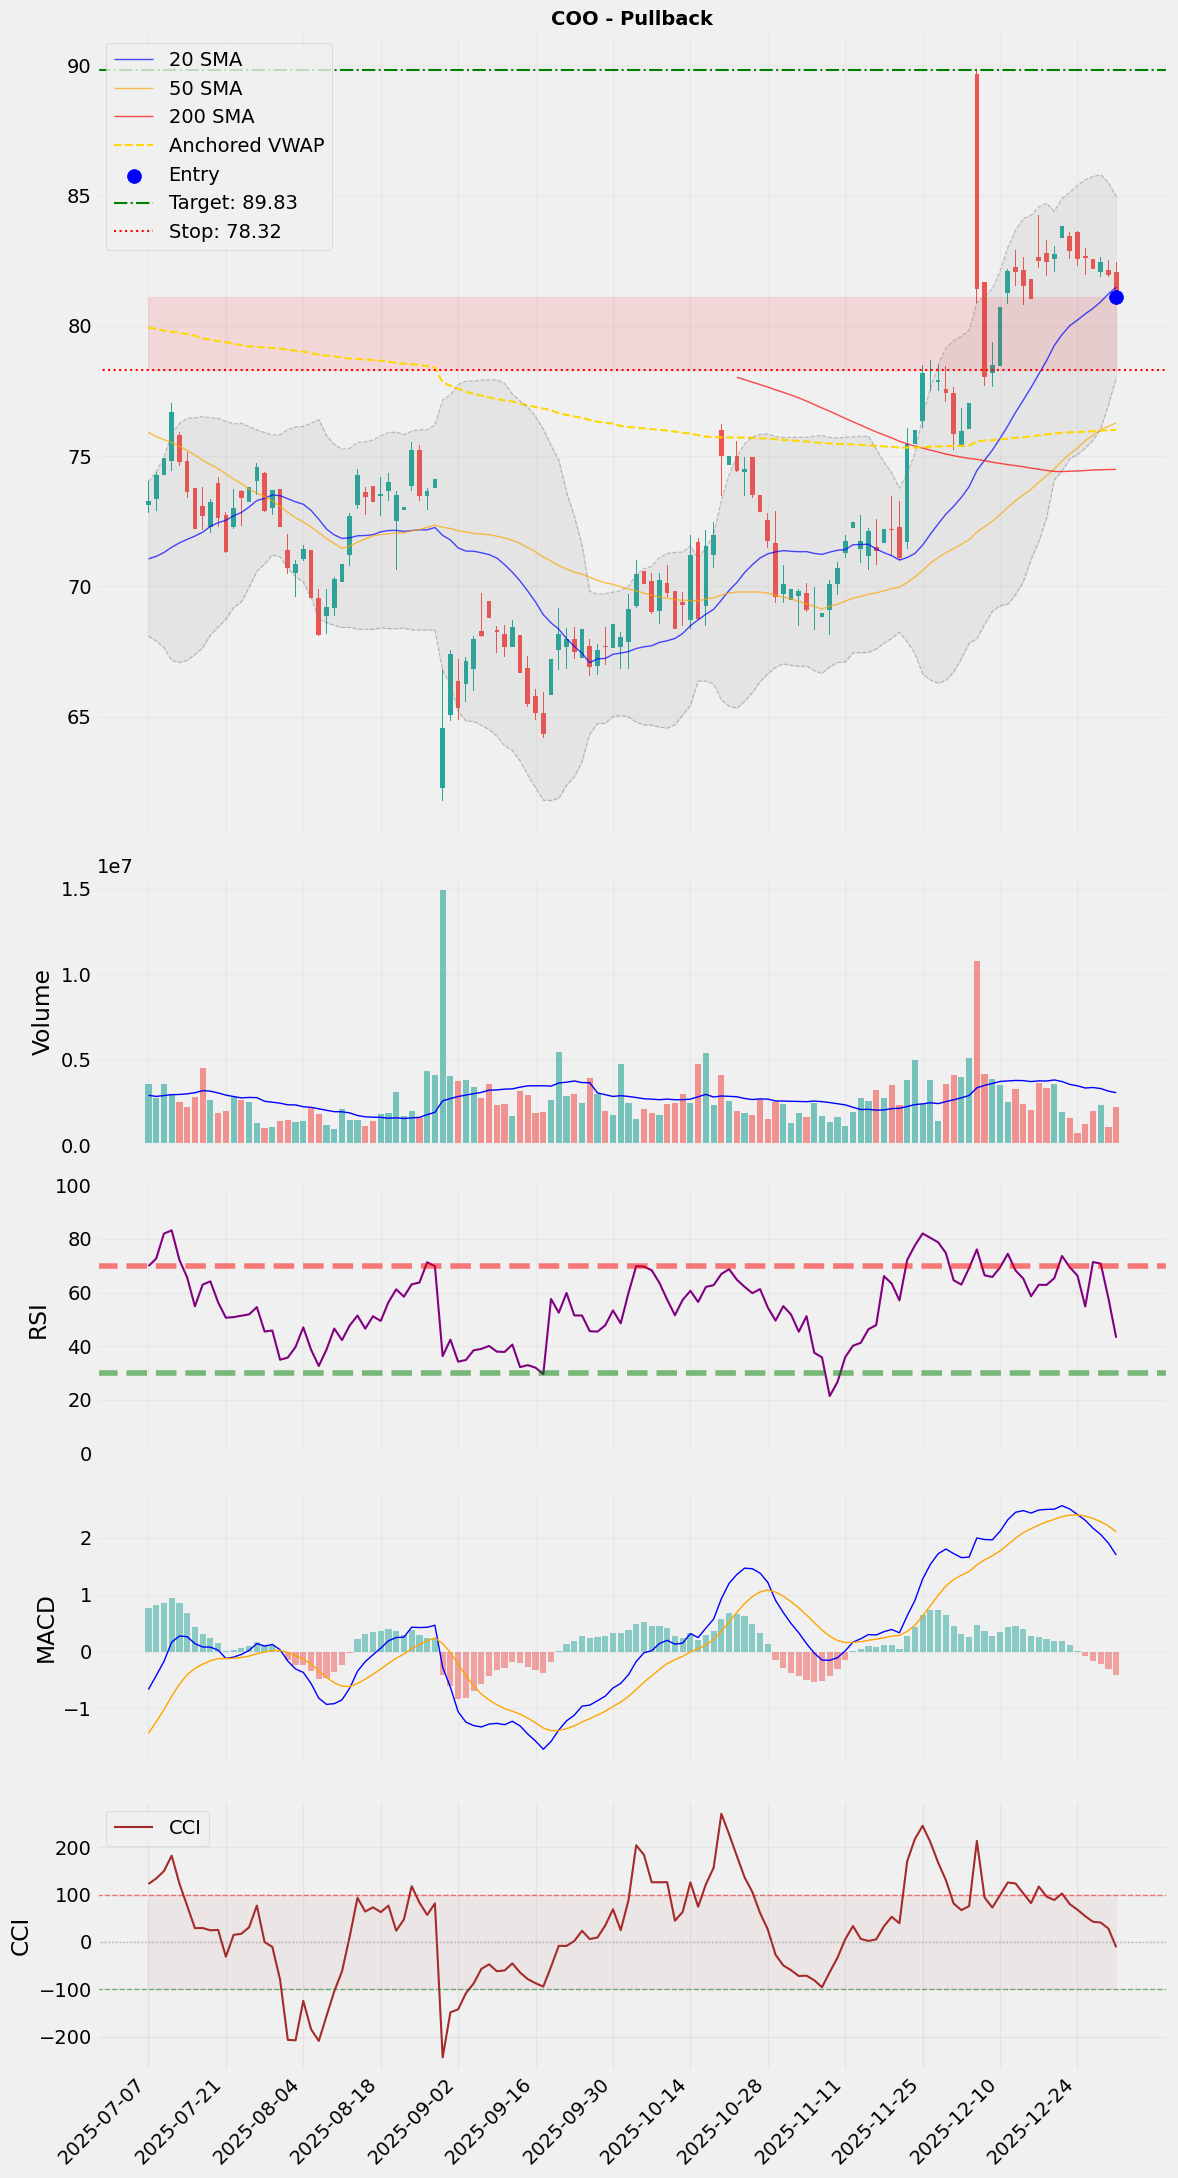

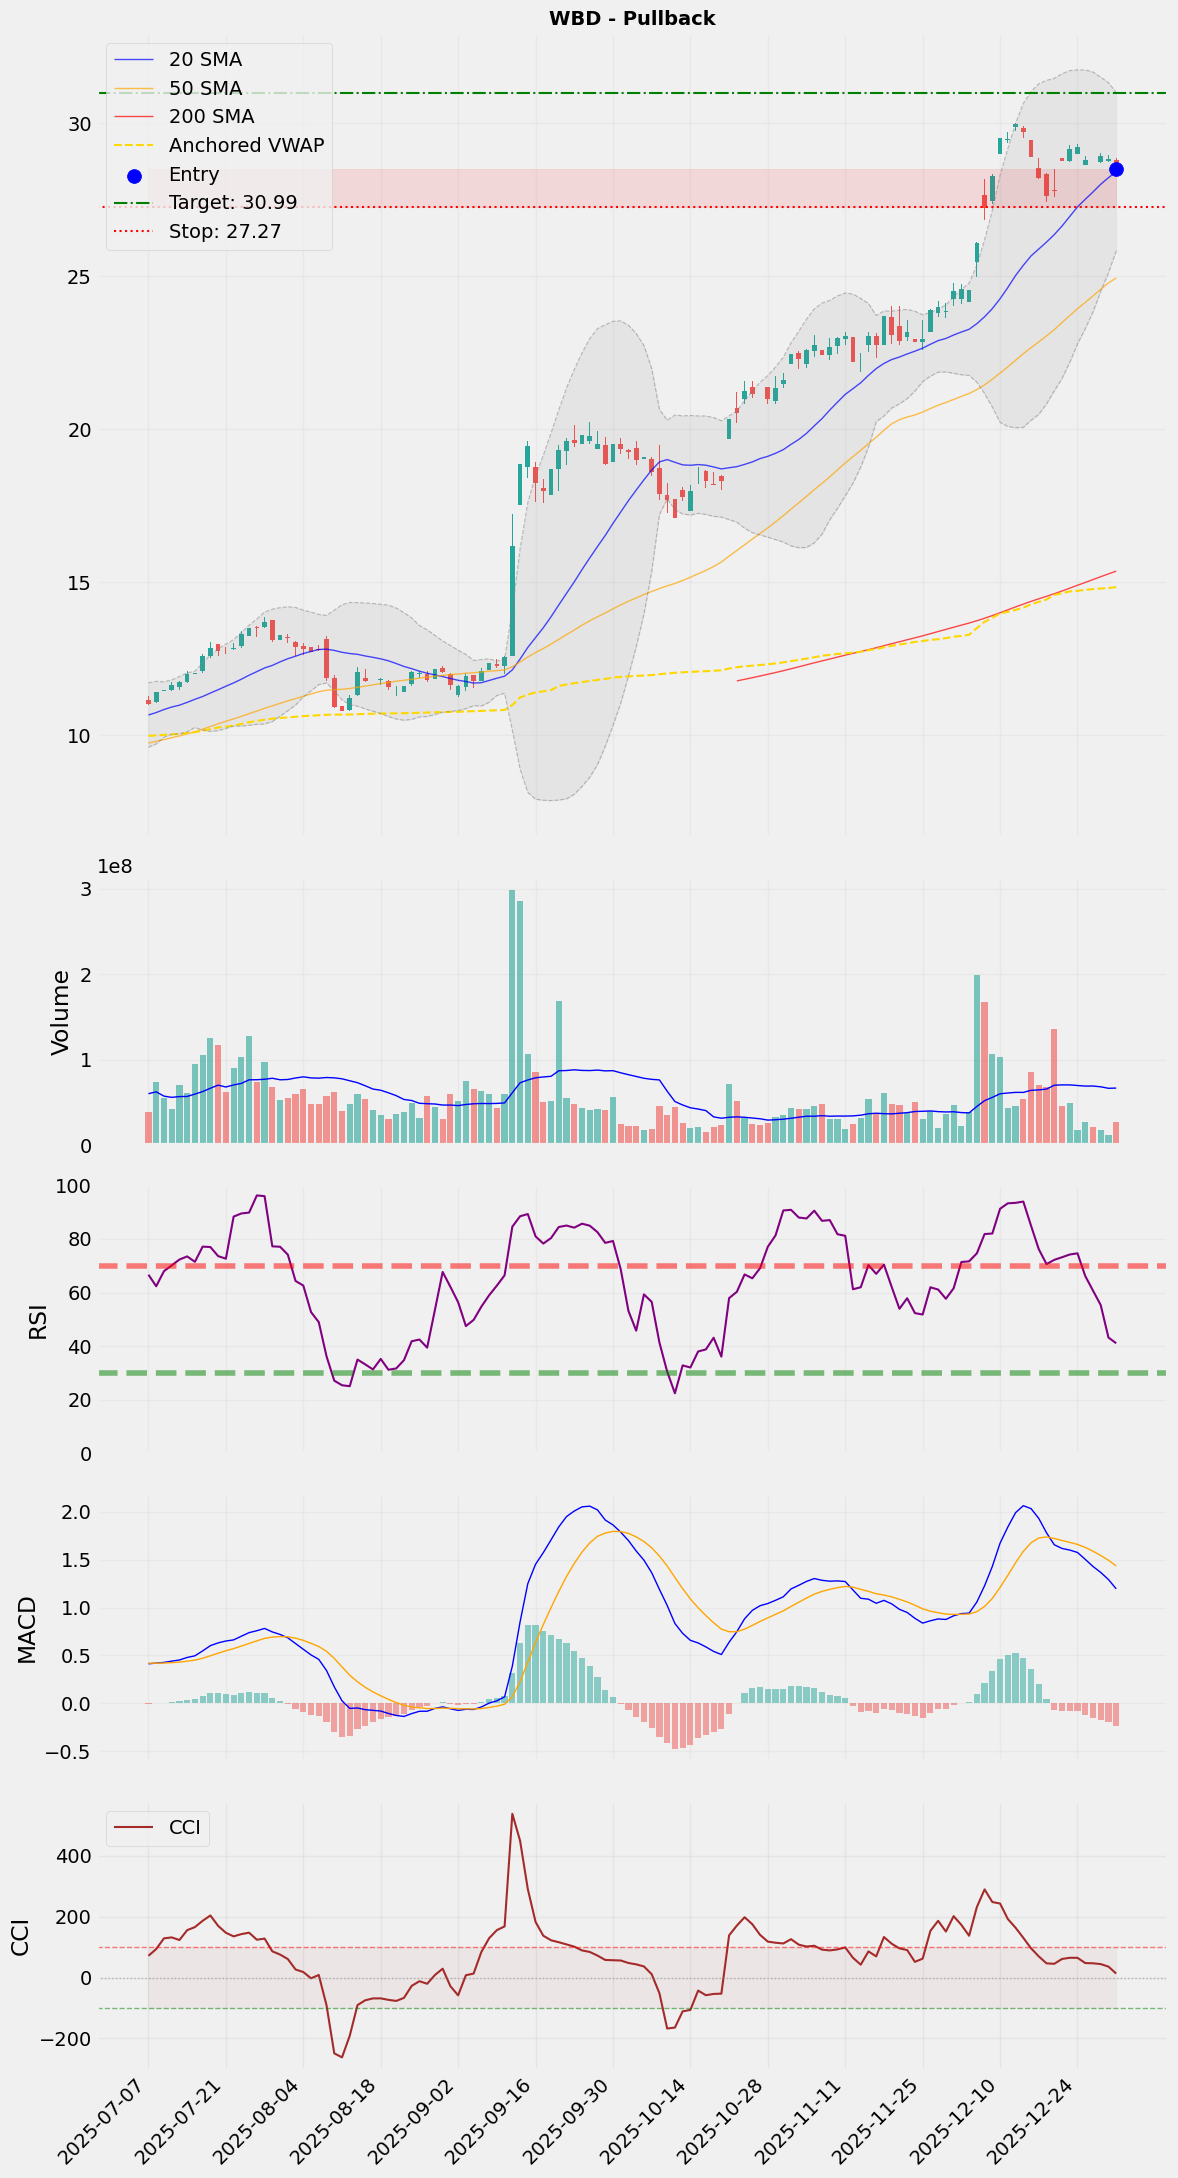

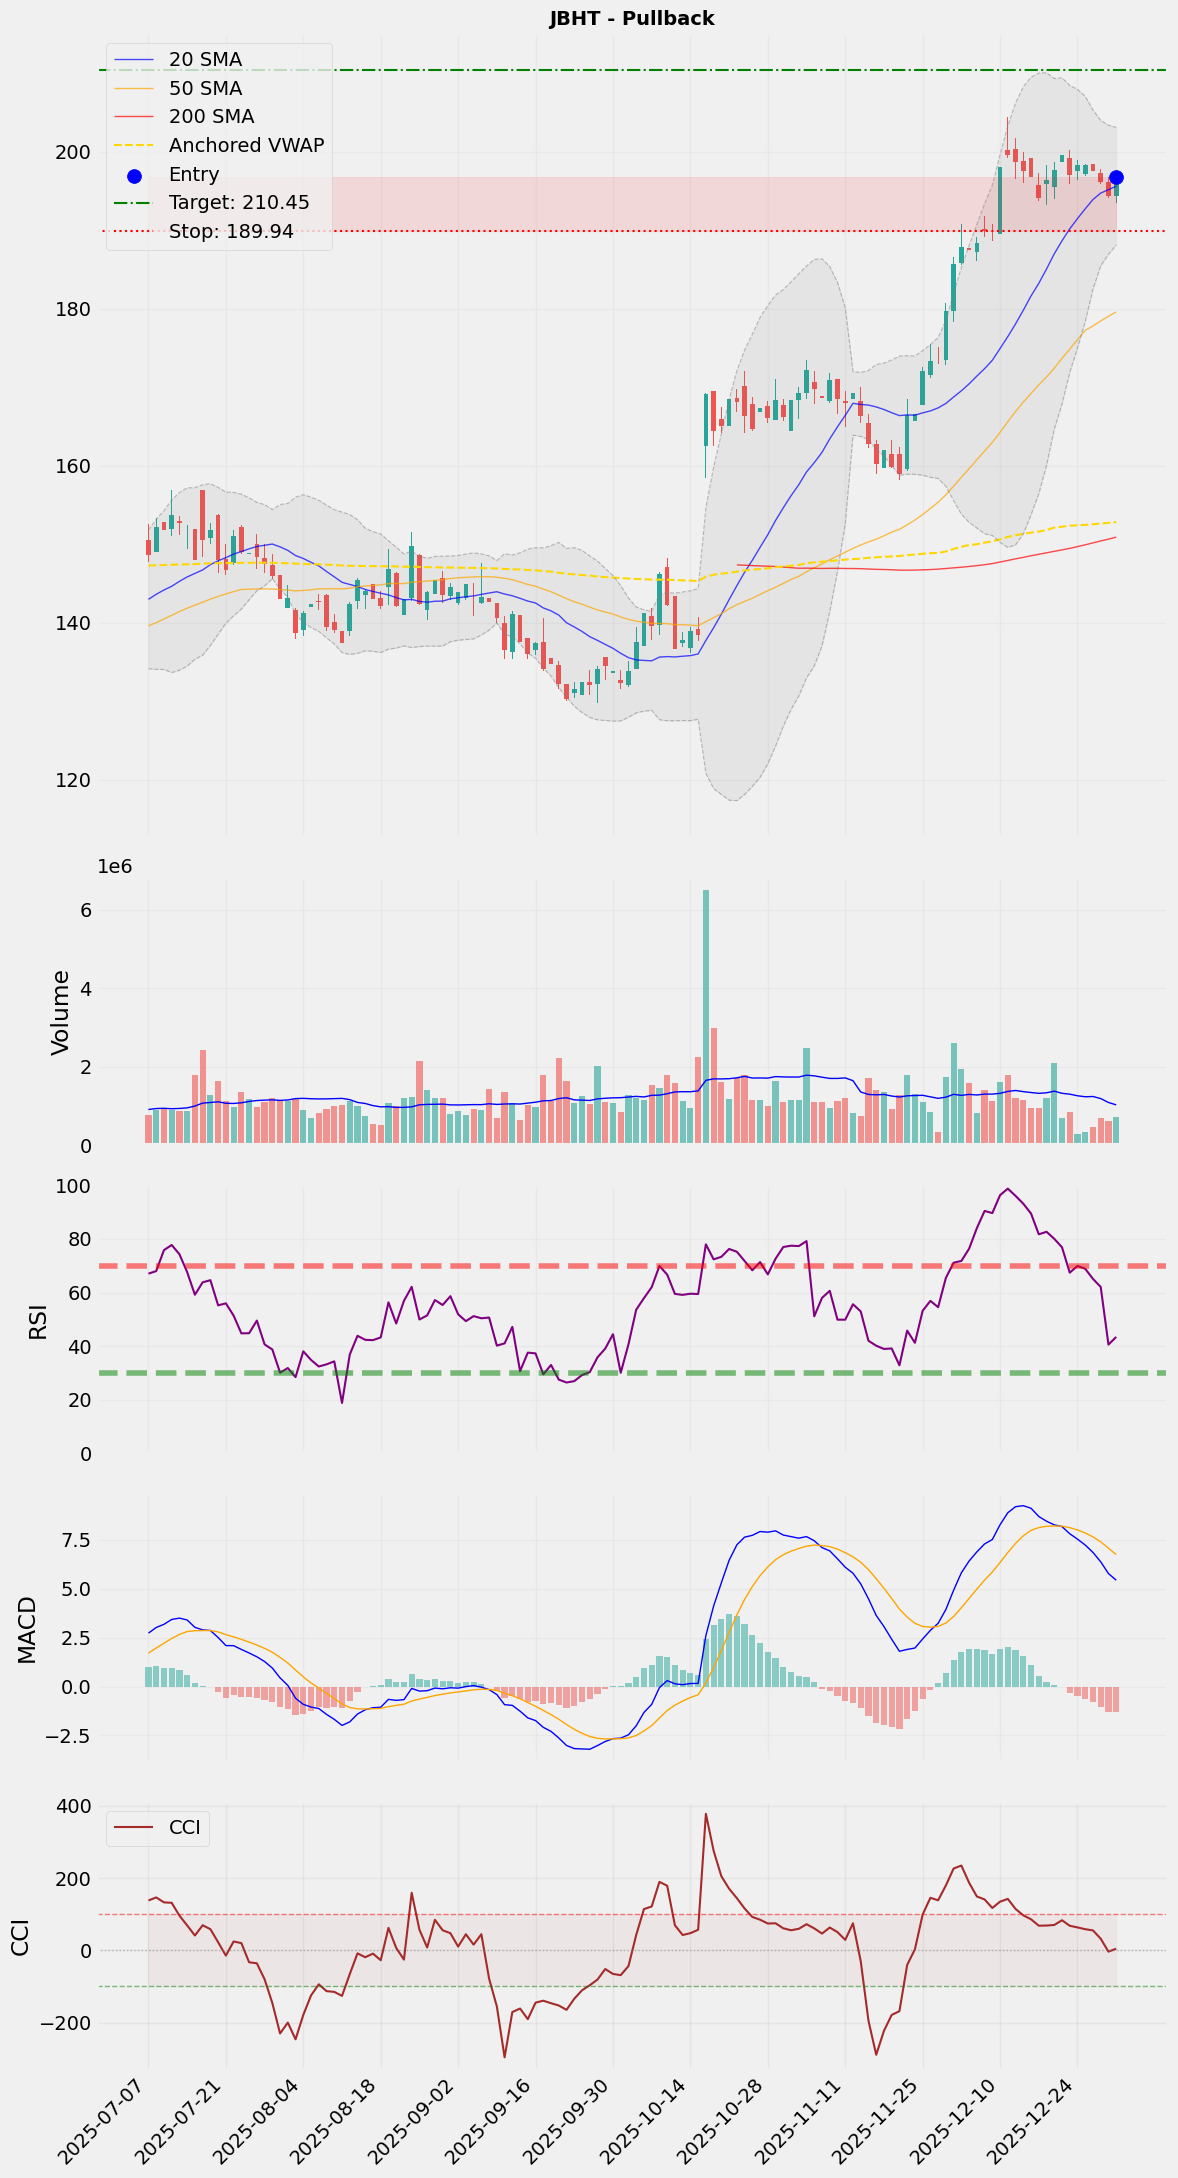

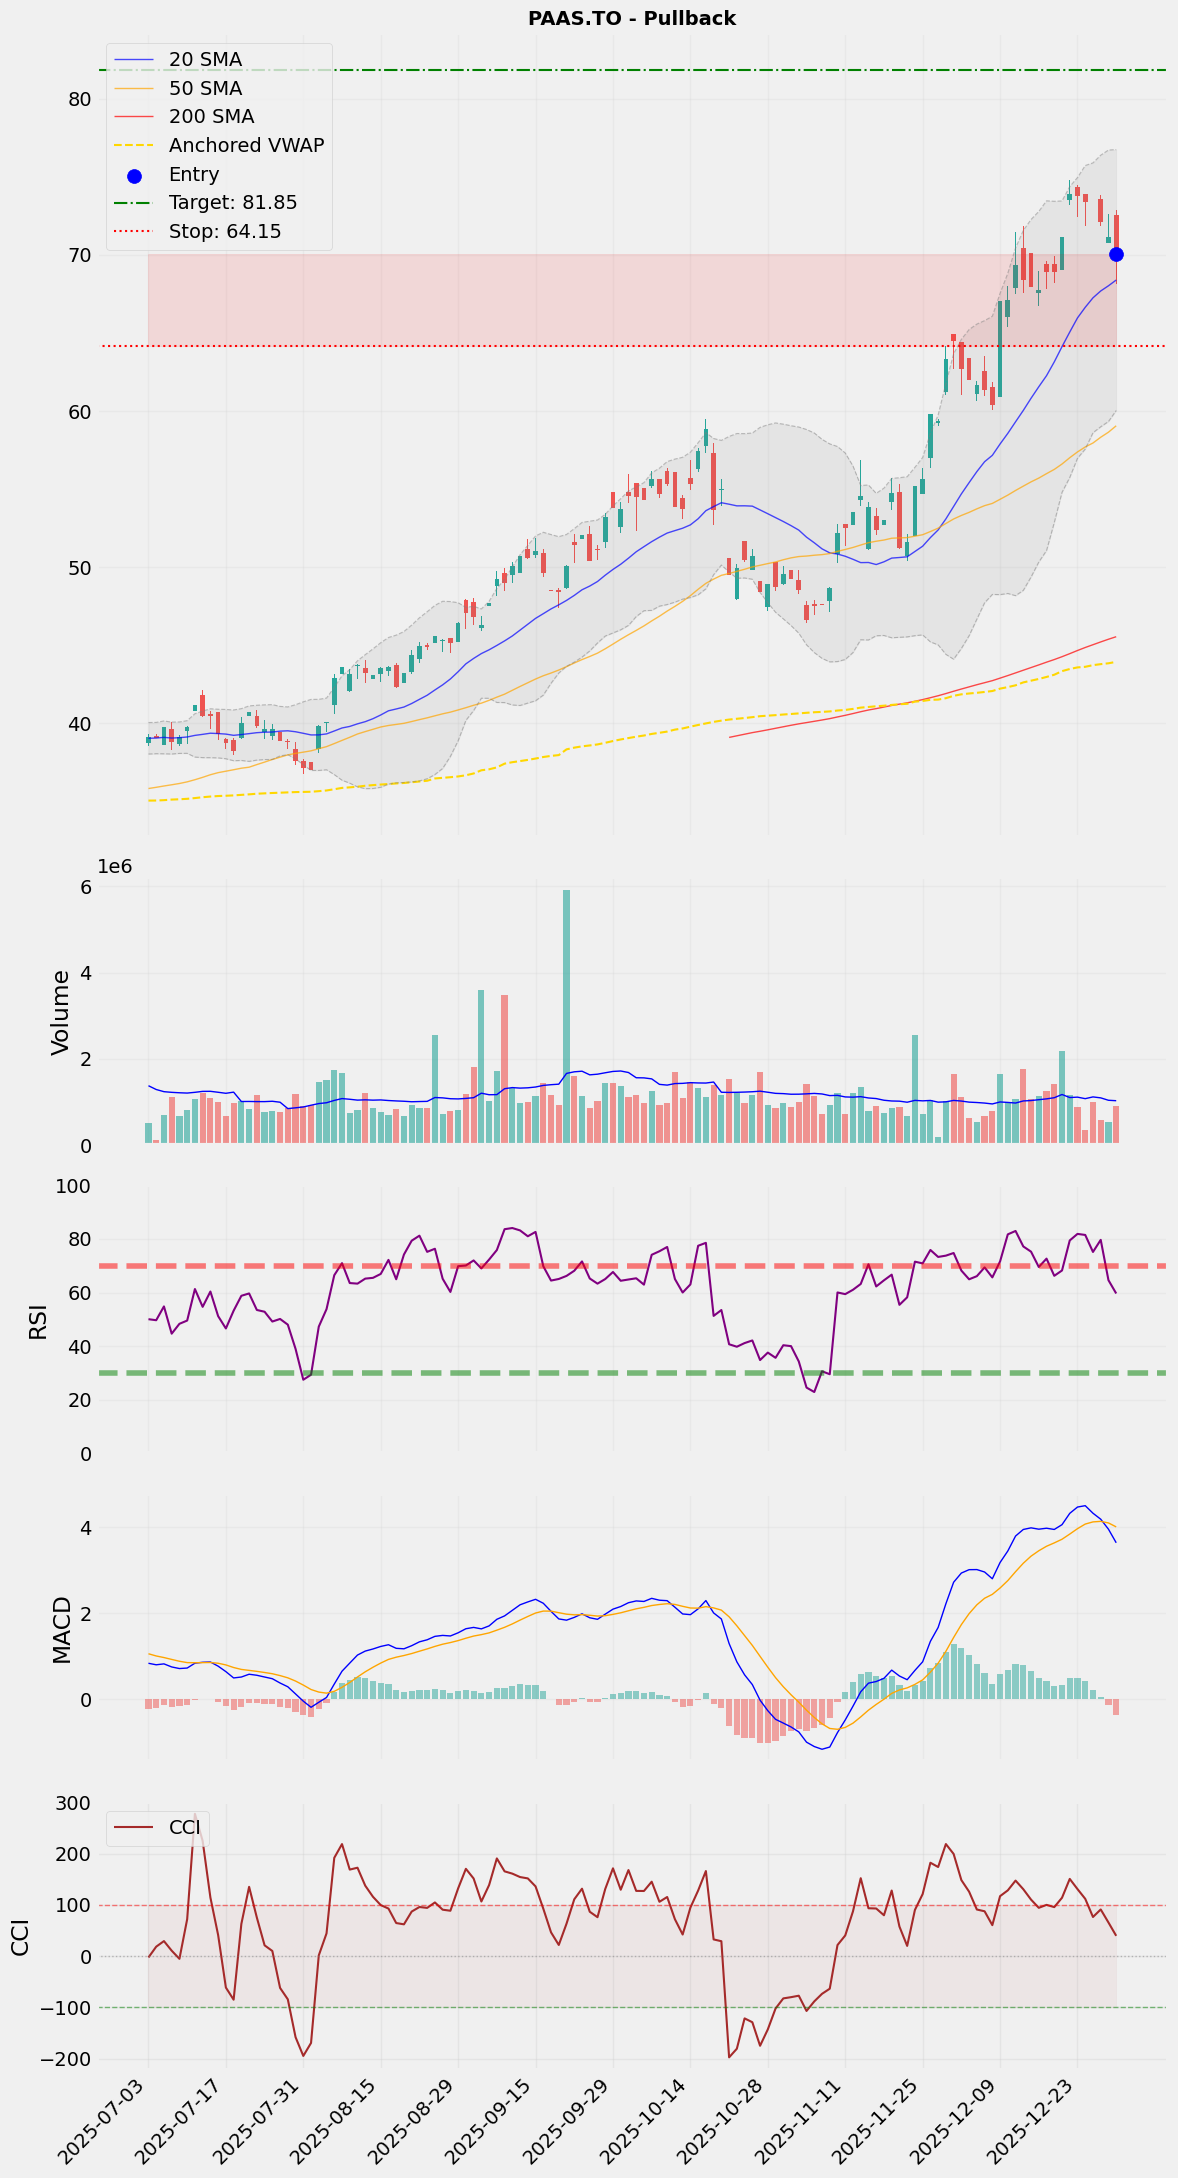

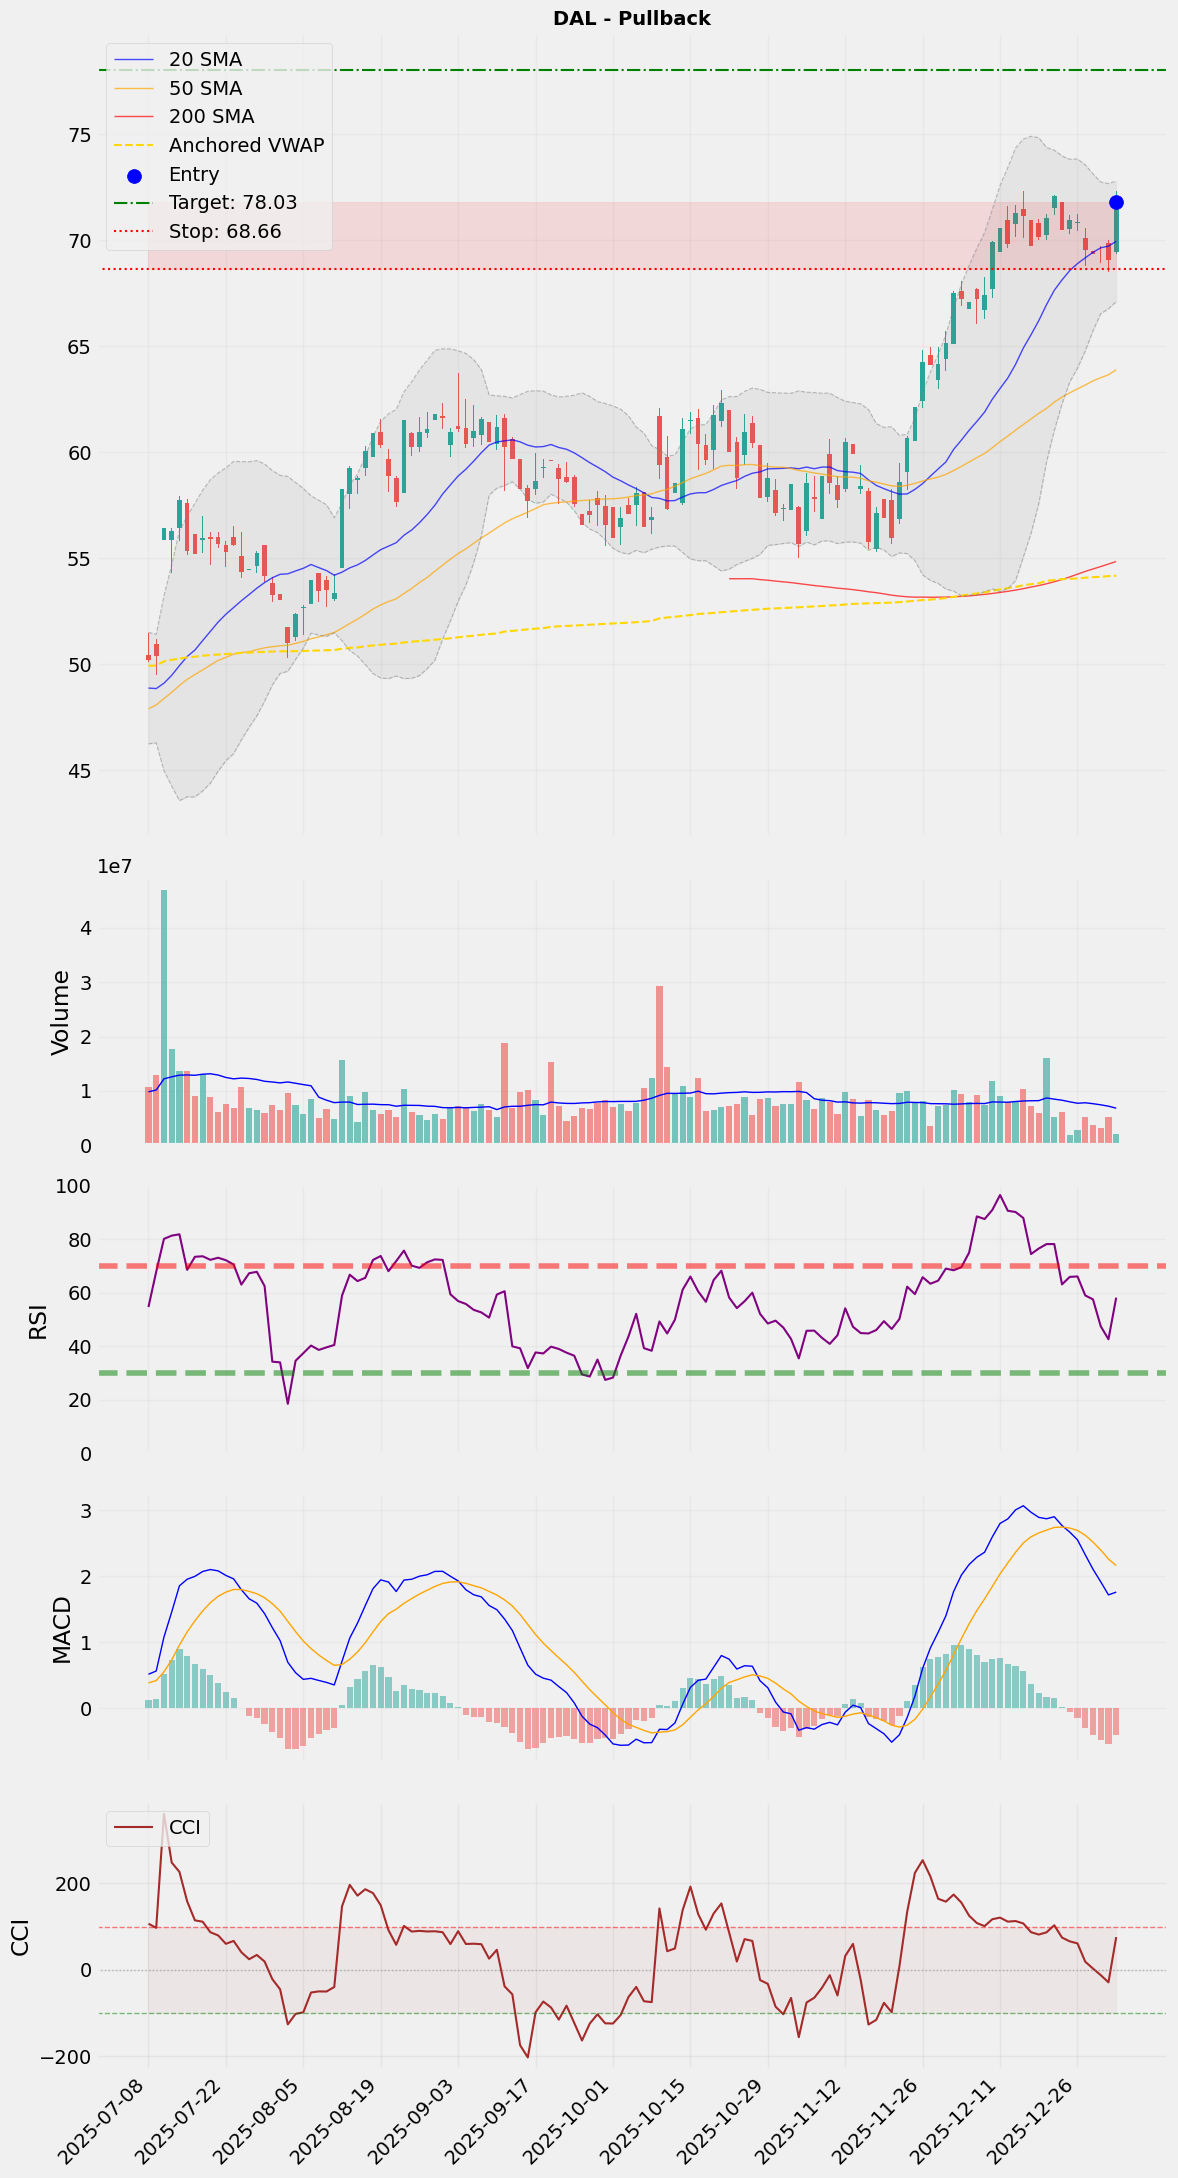


--- Charting Top Retest Setups ---


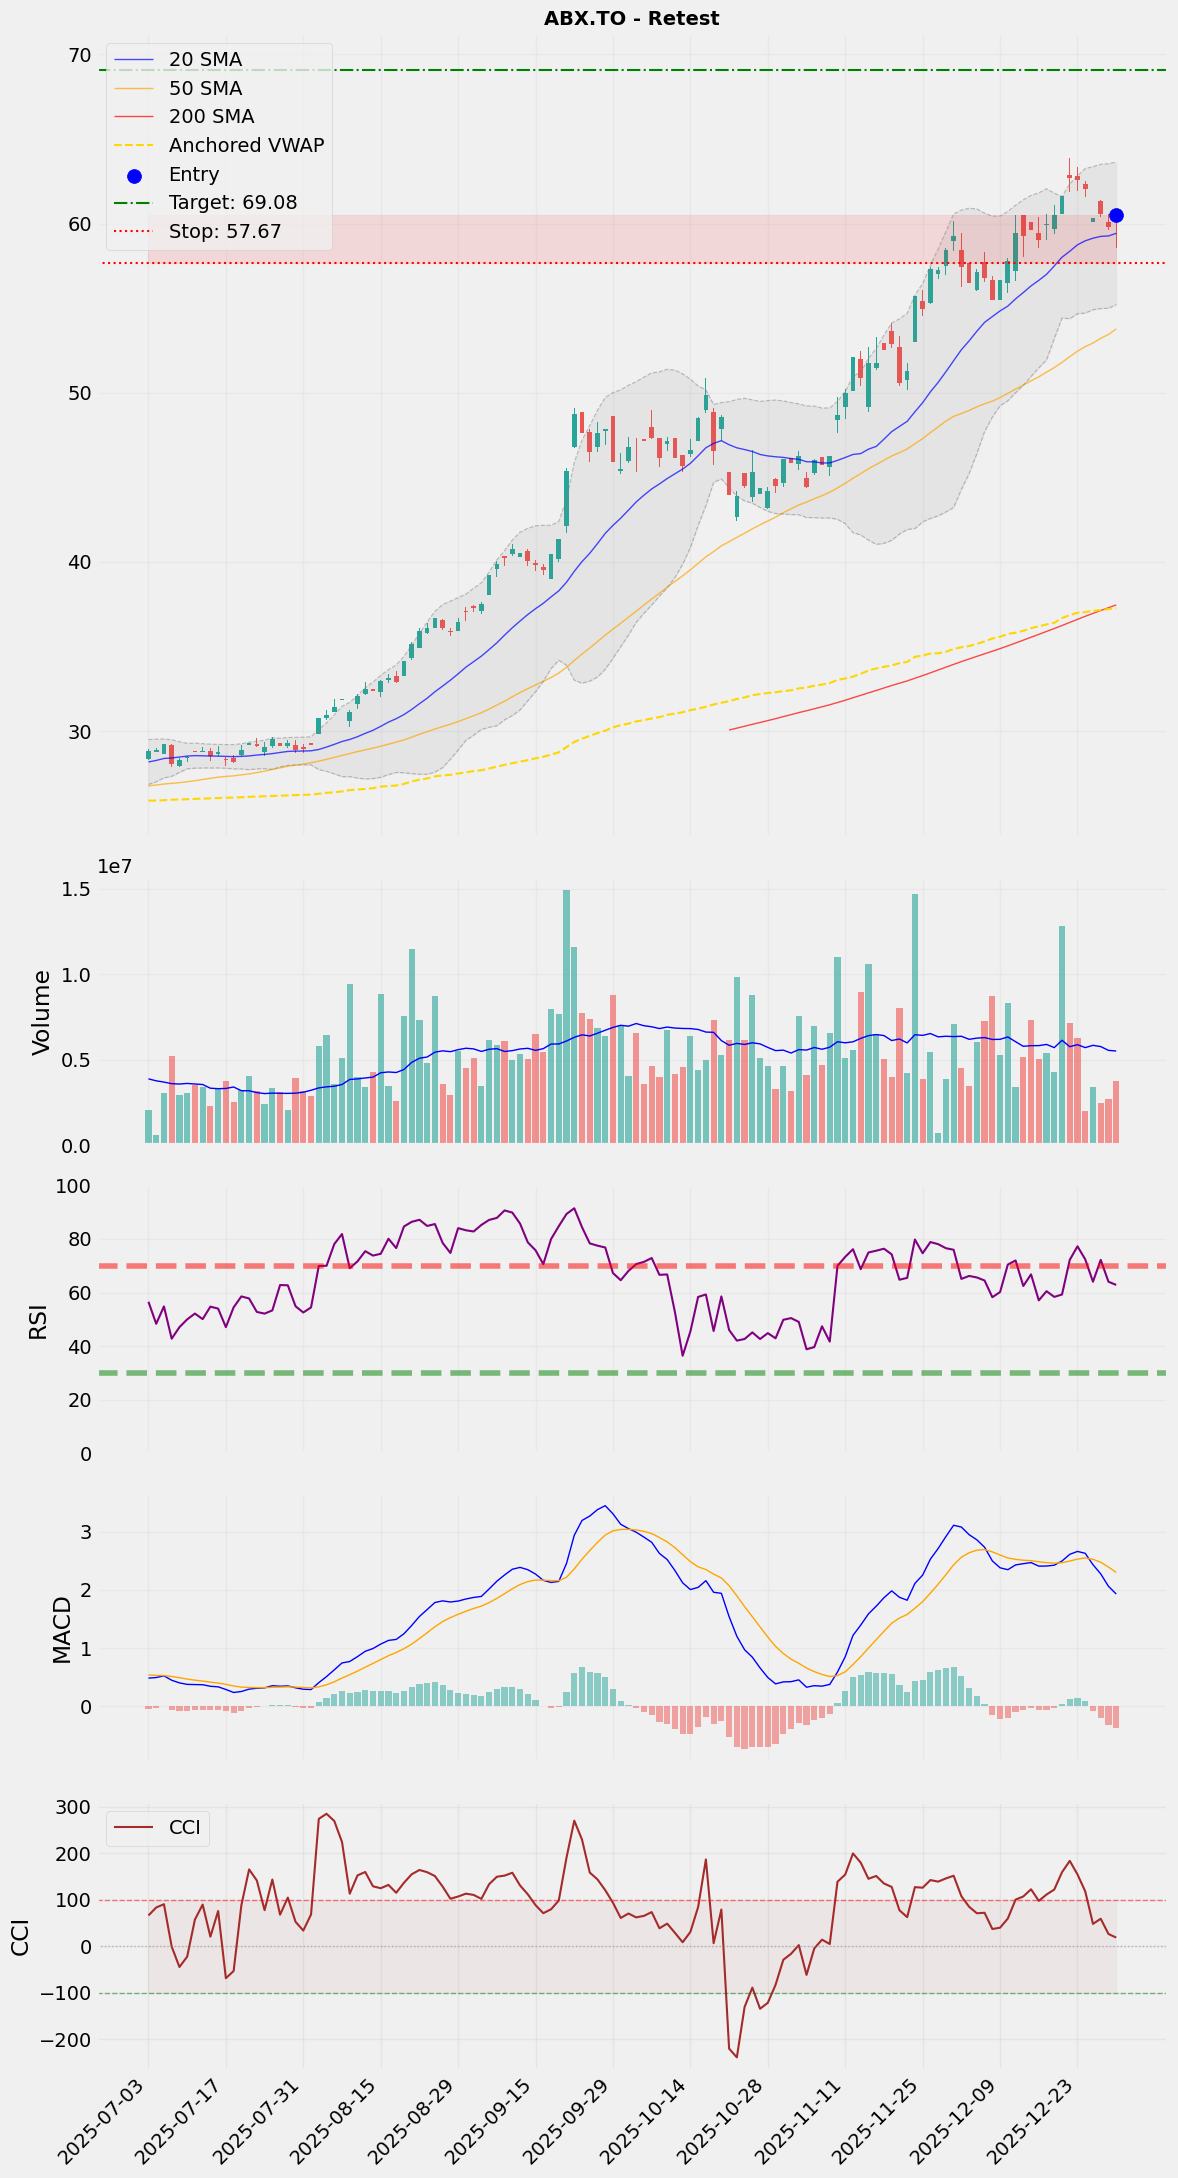

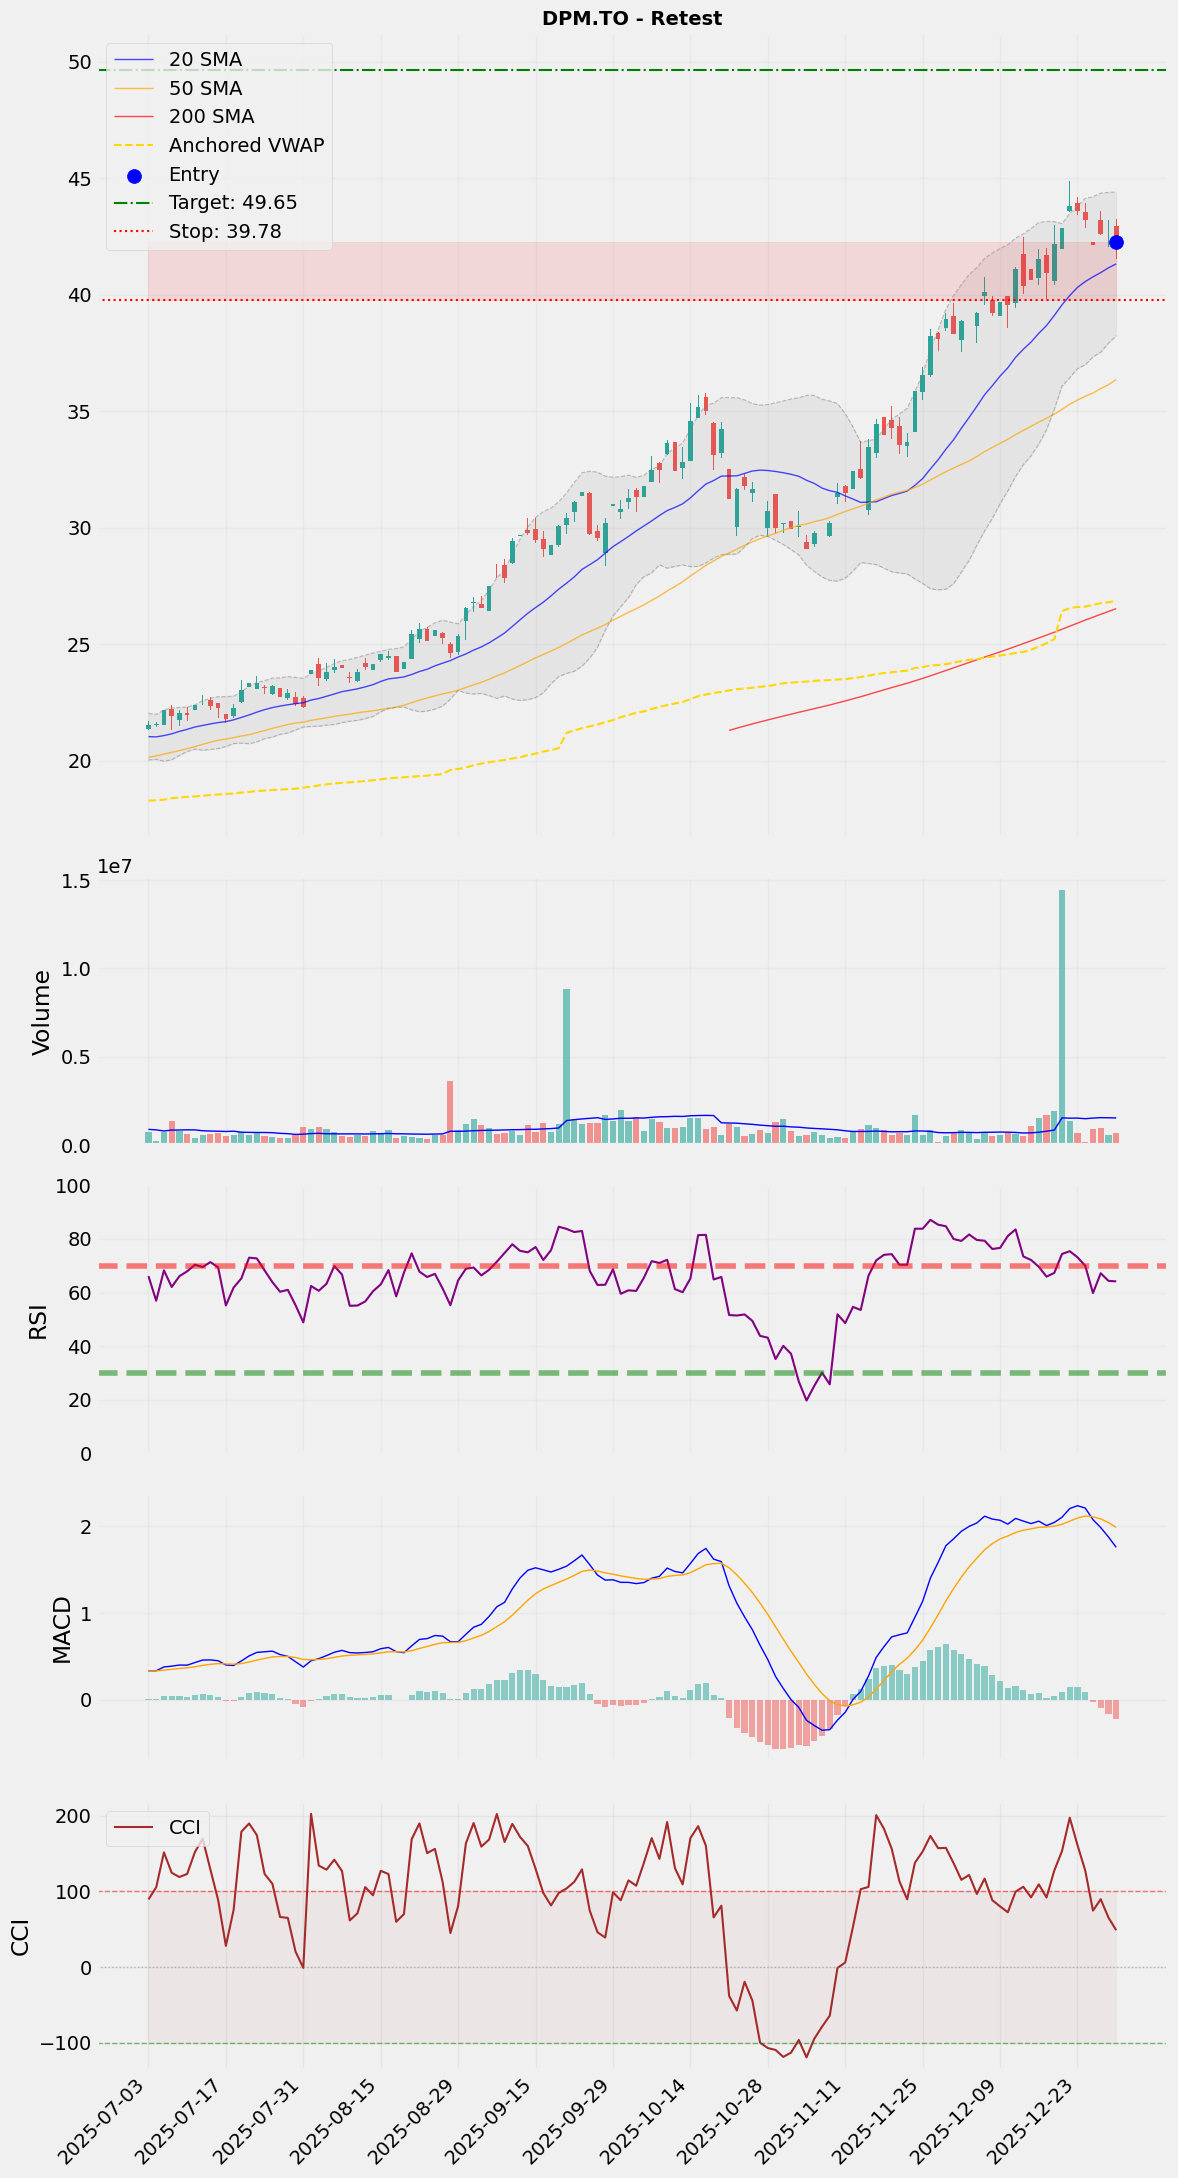

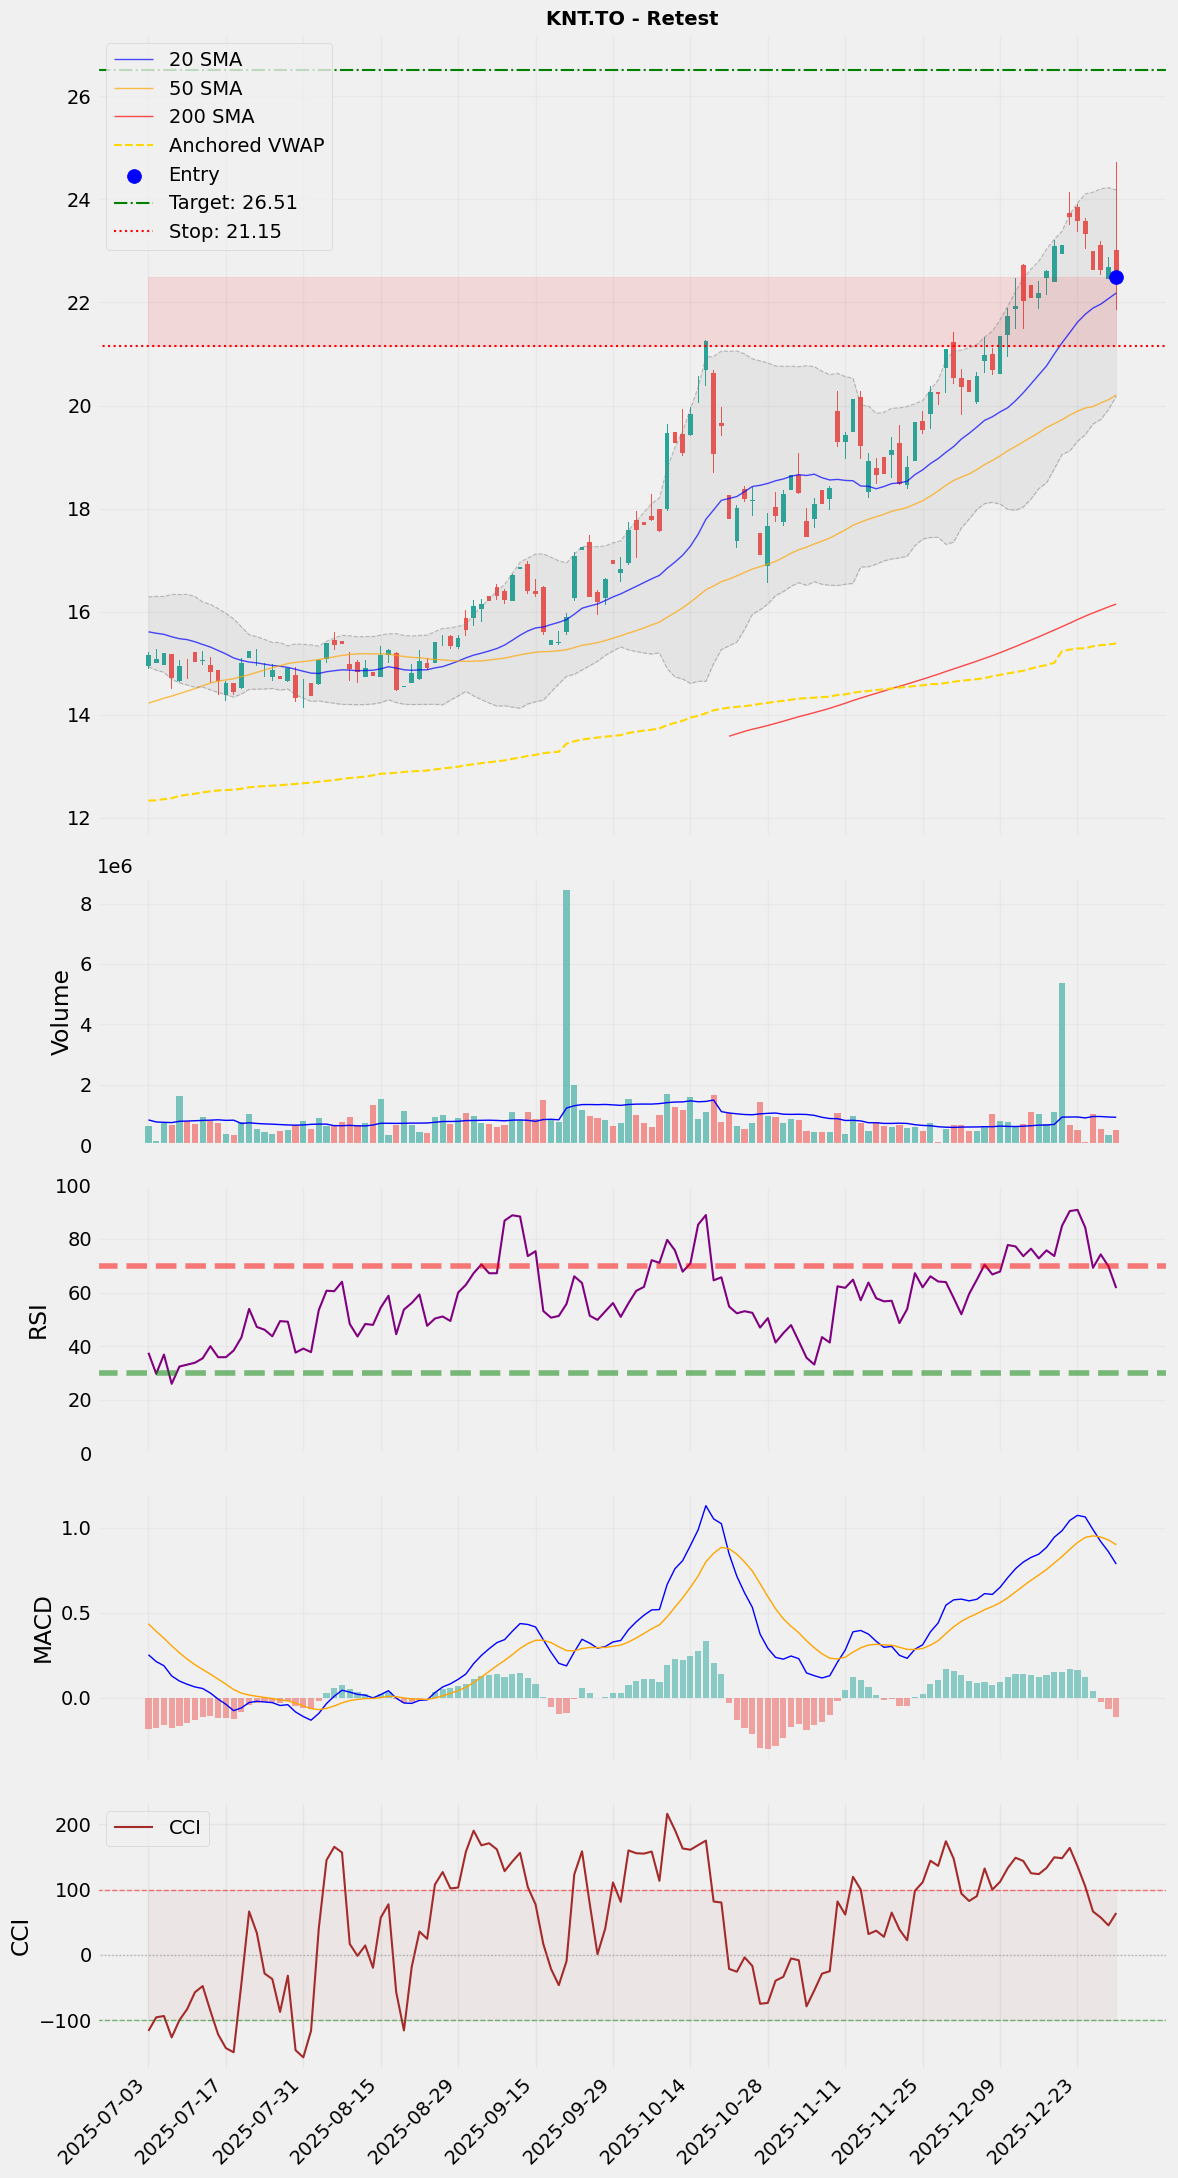

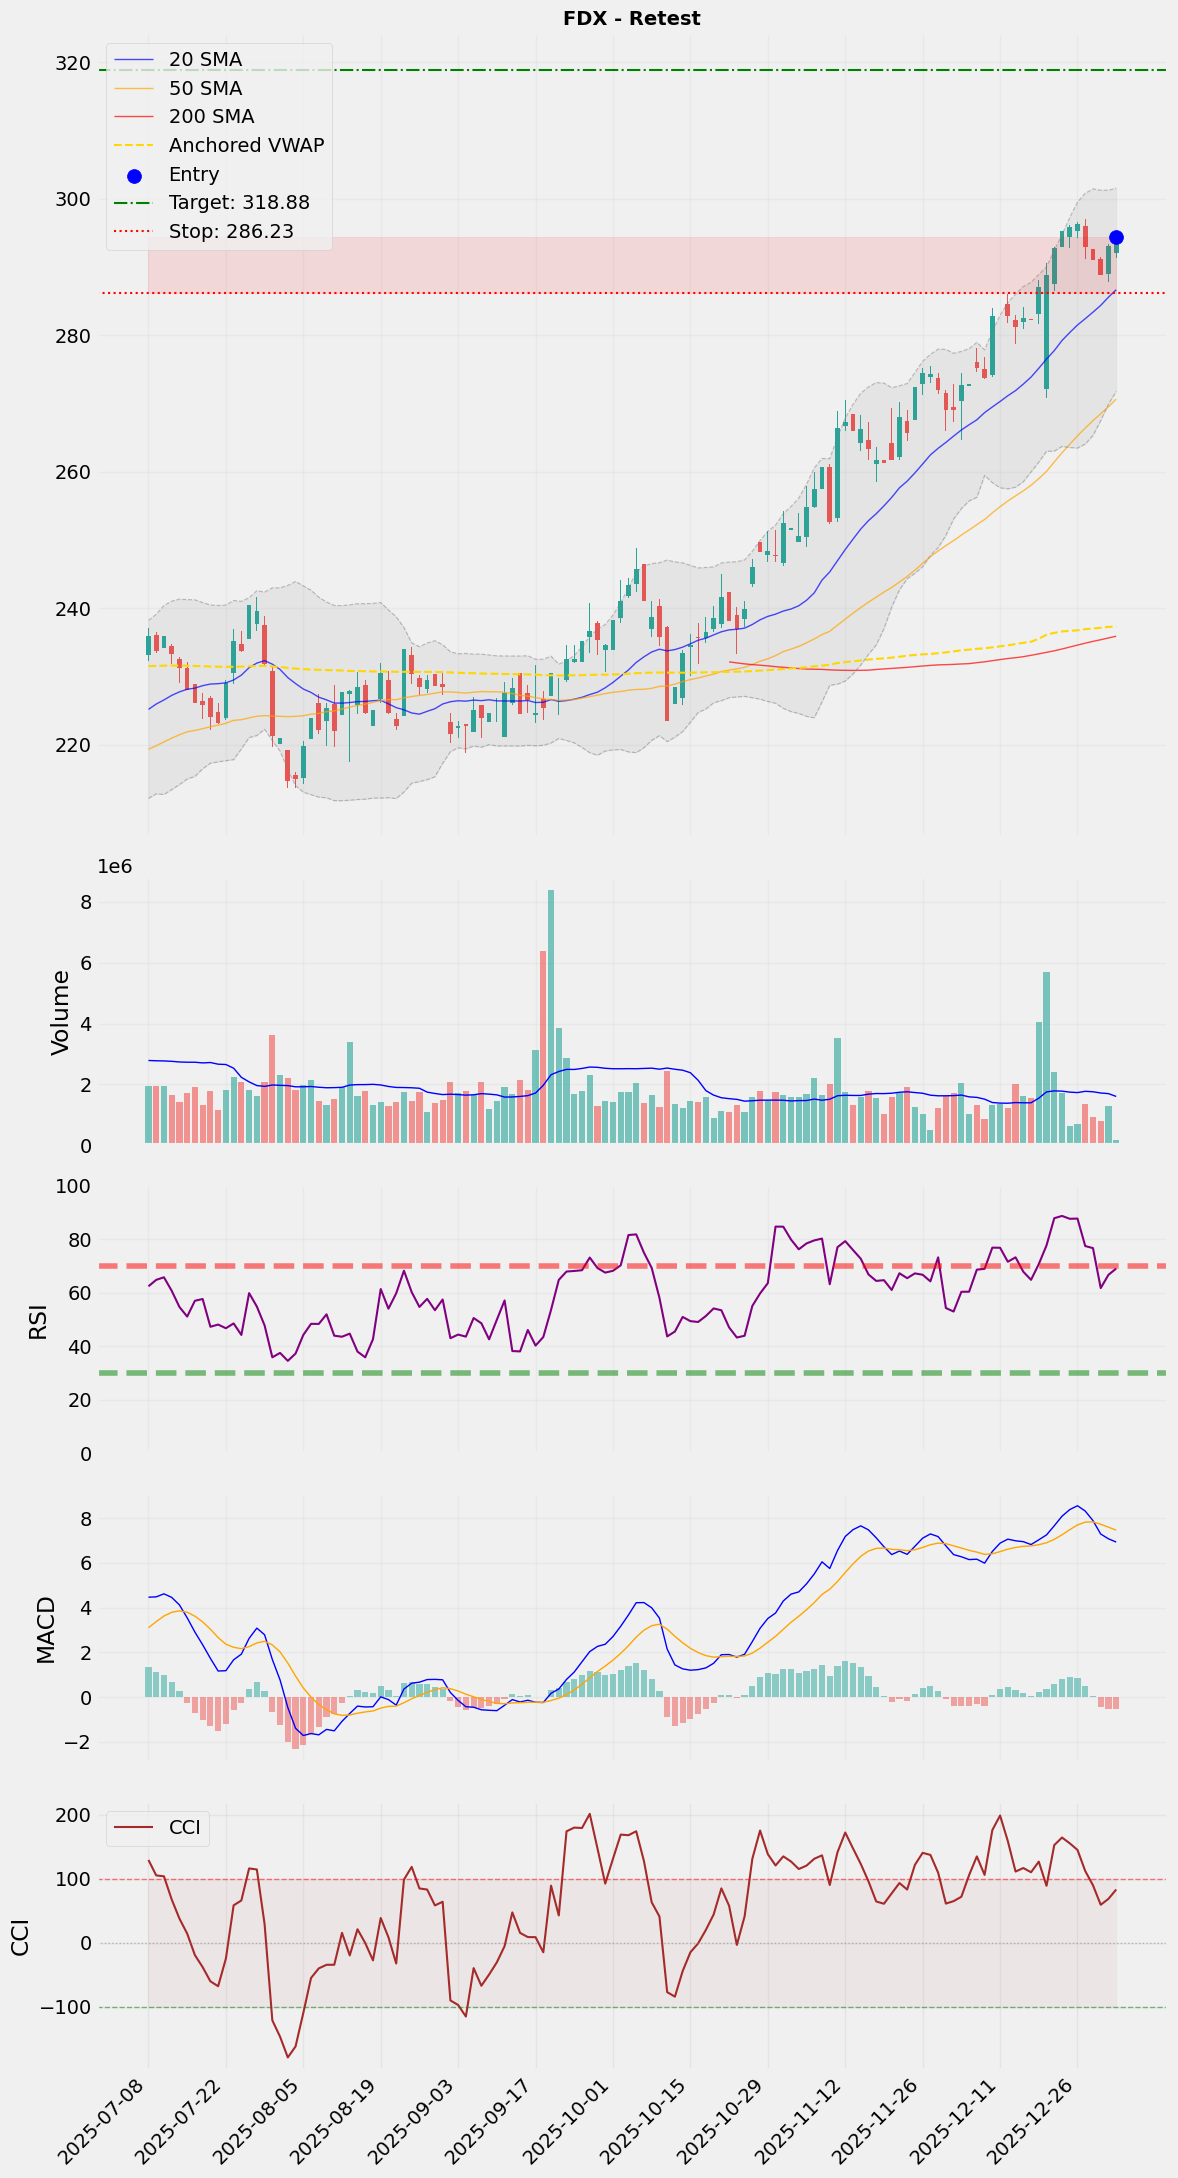

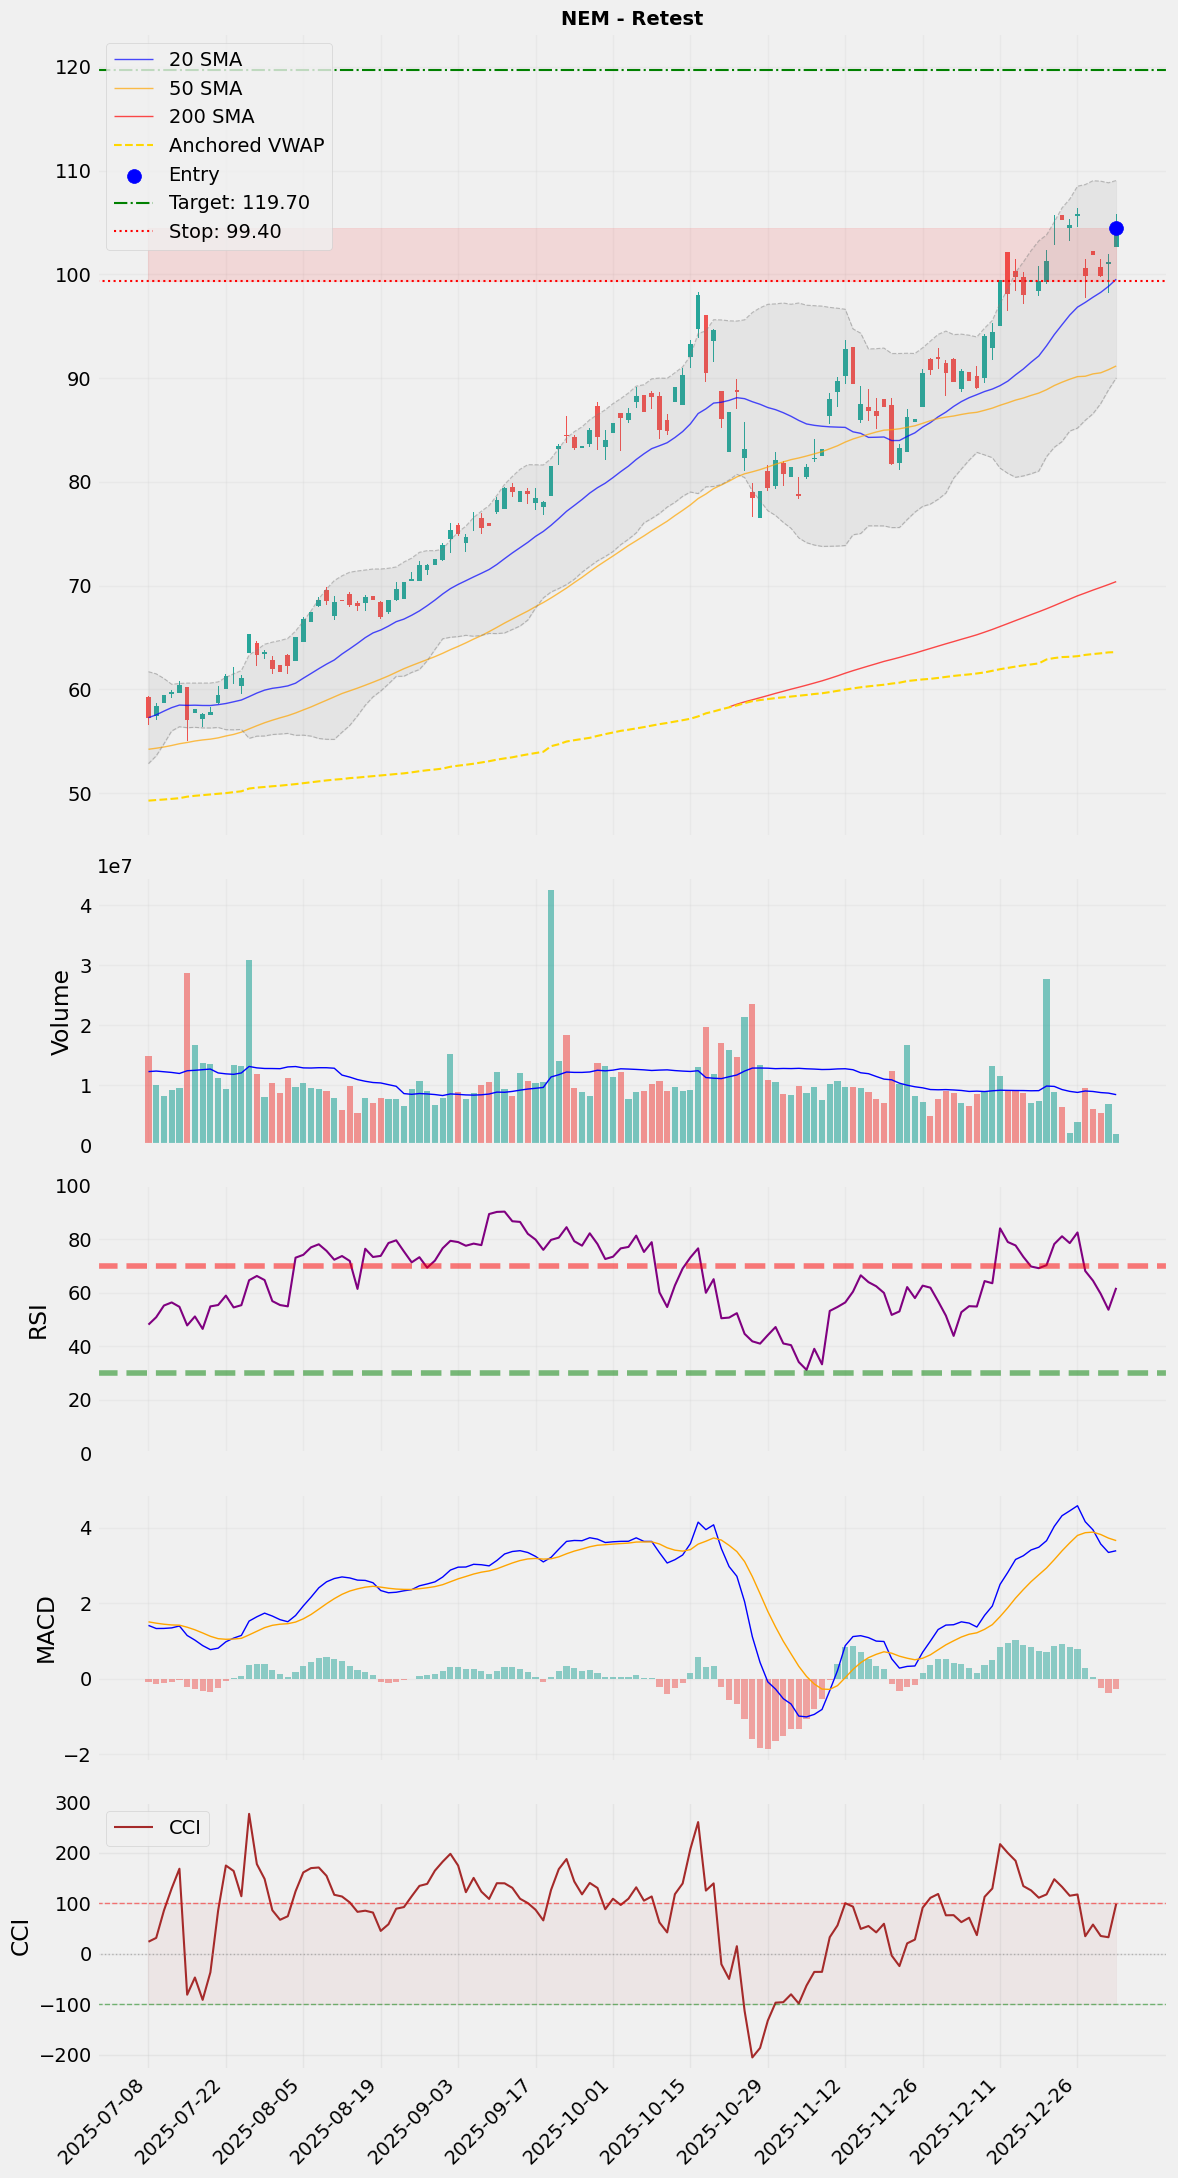


--- Charting Other Top Setups ---


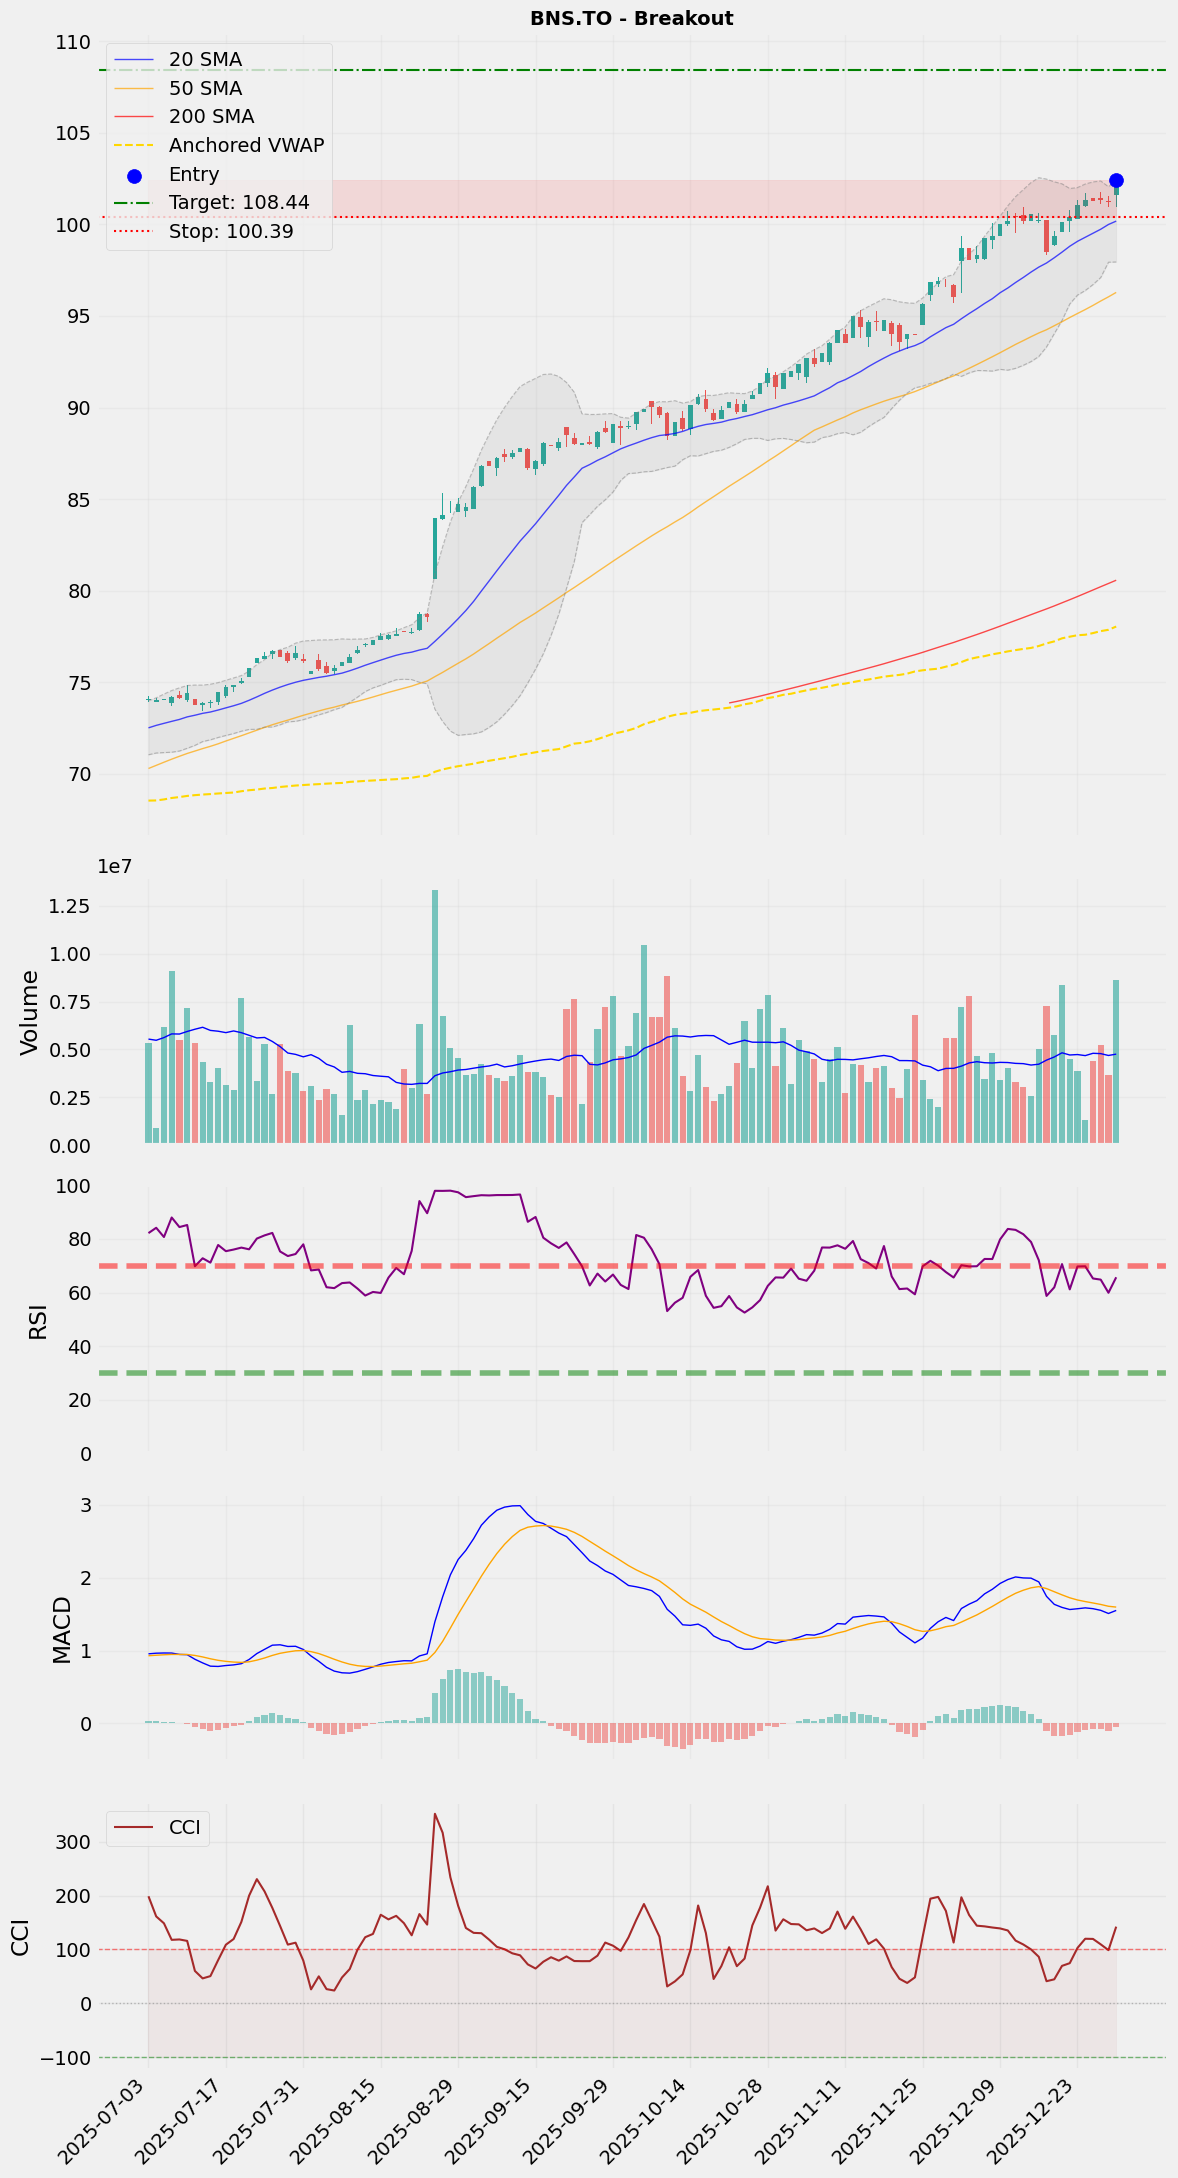

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def plot_candidate(ticker, df, signal_type, target=None, stop=None, entry_price=None):
    # Slice last 6 months
    plot_df = df.iloc[-126:].copy()
    plot_df = plot_df.reset_index() # Reset index to use integer indexing for bars
    
    # Create 5 subplots: Price, Volume, RSI, MACD, CCI
    fig, (ax1, ax_vol, ax2, ax3, ax4) = plt.subplots(5, 1, figsize=(12, 22), sharex=True, 
                                                gridspec_kw={'height_ratios': [3, 1, 1, 1, 1]})
    
    # --- AX1: Candlestick Chart ---
    # Define width of candlestick elements
    width = 0.6
    width2 = 0.1
    
    # Define colors
    up_color = '#26a69a'   # Green
    down_color = '#ef5350' # Red
    
    # Separate up and down days
    up = plot_df[plot_df.Close >= plot_df.Open]
    down = plot_df[plot_df.Close < plot_df.Open]
    
    # Plot Up Candles
    ax1.bar(up.index, up.Close - up.Open, width, bottom=up.Open, color=up_color)
    ax1.bar(up.index, up.High - up.Close, width2, bottom=up.Close, color=up_color)
    ax1.bar(up.index, up.Low - up.Open, width2, bottom=up.Open, color=up_color)
    
    # Plot Down Candles
    ax1.bar(down.index, down.Close - down.Open, width, bottom=down.Open, color=down_color)
    ax1.bar(down.index, down.High - down.Open, width2, bottom=down.Open, color=down_color)
    ax1.bar(down.index, down.Low - down.Close, width2, bottom=down.Close, color=down_color)
    
    # Plot Moving Averages
    ax1.plot(plot_df.index, plot_df[f'SMA_{MA_SHORT}'], label=f'{MA_SHORT} SMA', color='blue', linewidth=1, alpha=0.7)
    ax1.plot(plot_df.index, plot_df[f'SMA_{MA_MED}'], label=f'{MA_MED} SMA', color='orange', linewidth=1, alpha=0.7)
    ax1.plot(plot_df.index, plot_df[f'SMA_{MA_LONG}'], label=f'{MA_LONG} SMA', color='red', linewidth=1, alpha=0.7)
    
    # Anchored VWAP
    if 'AVWAP' in plot_df.columns:
        ax1.plot(plot_df.index, plot_df['AVWAP'], label='Anchored VWAP', color='gold', linestyle='--', linewidth=1.5)

    # Bollinger Bands
    if 'BB_Upper' in plot_df.columns:
        ax1.plot(plot_df.index, plot_df['BB_Upper'], color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
        ax1.plot(plot_df.index, plot_df['BB_Lower'], color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
        ax1.fill_between(plot_df.index, plot_df['BB_Upper'], plot_df['BB_Lower'], color='gray', alpha=0.1)

    # Visuals: Targets & Stops
    last_idx = plot_df.index[-1]
    if entry_price:
        ax1.scatter(last_idx, entry_price, color='blue', s=100, zorder=5, label='Entry')
    if target:
        ax1.axhline(target, color='green', linestyle='-.', linewidth=1.5, label=f'Target: {target:.2f}')
    if stop:
        ax1.axhline(stop, color='red', linestyle=':', linewidth=1.5, label=f'Stop: {stop:.2f}')
        # Shade the risk area
        ax1.fill_between(plot_df.index, stop, entry_price, color='red', alpha=0.1)

    ax1.set_title(f"{ticker} - {signal_type}", fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.2)
    
    # --- AX_VOL: Volume ---
    ax_vol.bar(plot_df.index, plot_df['Volume'], color=np.where(plot_df['Close'] >= plot_df['Open'], up_color, down_color), alpha=0.6)
    
    # Add Volume SMA
    if 'Vol_SMA' in plot_df.columns:
        ax_vol.plot(plot_df.index, plot_df['Vol_SMA'], color='blue', linewidth=1, label='Vol SMA (20)')
    
    ax_vol.set_ylabel('Volume')
    ax_vol.grid(True, alpha=0.2)
    
    # --- AX2: RSI ---
    ax2.plot(plot_df.index, plot_df['RSI'], color='purple', linewidth=1.5)
    ax2.axhline(70, color='red', linestyle='--', alpha=0.5)
    ax2.axhline(30, color='green', linestyle='--', alpha=0.5)
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.grid(True, alpha=0.2)
    
    # --- AX3: MACD ---
    ax3.plot(plot_df.index, plot_df['MACD'], color='blue', linewidth=1)
    ax3.plot(plot_df.index, plot_df['MACD_Signal'], color='orange', linewidth=1)
    ax3.bar(plot_df.index, plot_df['MACD_Hist'], color=np.where(plot_df['MACD_Hist']>=0, up_color, down_color), alpha=0.5)
    ax3.set_ylabel('MACD')
    ax3.grid(True, alpha=0.2)

    # --- AX4: CCI ---
    if 'CCI' in plot_df.columns:
        ax4.plot(plot_df.index, plot_df['CCI'], label='CCI', color='brown', linewidth=1.5)
        ax4.axhline(100, color='red', linestyle='--', linewidth=1, alpha=0.5)
        ax4.axhline(-100, color='green', linestyle='--', linewidth=1, alpha=0.5)
        ax4.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        ax4.fill_between(plot_df.index, 100, -100, color='brown', alpha=0.05)
        ax4.set_ylabel('CCI')
        ax4.legend(loc='upper left')
        ax4.grid(True, alpha=0.3)
    
    # Fix X-Axis Dates (Since we used integer indexing for bars)
    # Show every 10th date
    ticks = np.arange(0, len(plot_df), 10)
    ax4.set_xticks(ticks)
    
    # Handle Date column name (yfinance usually gives 'Date' or index)
    date_col = 'Date' if 'Date' in plot_df.columns else 'index'
    if date_col in plot_df.columns:
        ax4.set_xticklabels(plot_df[date_col].iloc[ticks].dt.strftime('%Y-%m-%d'), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Run the plotter on the results
if 'results_df' in locals() and not results_df.empty:
    
    # 1. Plot Pullbacks
    pullback_df = results_df[results_df['Signal'] == 'Pullback'].head(5)
    if not pullback_df.empty:
        print(f"\n--- Charting Top Pullback Setups ---")
        for index, row in pullback_df.iterrows():
            ticker = row['Ticker']
            if ticker in data_store:
                plot_candidate(ticker, data_store[ticker], row['Signal'], row.get('Target'), row.get('Stop'), row.get('Close'))

    # 2. Plot Retests
    retest_df = results_df[results_df['Signal'] == 'Retest'].head(5)
    if not retest_df.empty:
        print(f"\n--- Charting Top Retest Setups ---")
        for index, row in retest_df.iterrows():
            ticker = row['Ticker']
            if ticker in data_store:
                plot_candidate(ticker, data_store[ticker], row['Signal'], row.get('Target'), row.get('Stop'), row.get('Close'))
                
    # 3. Plot Others (Optional, maybe top 2)
    other_df = results_df[~results_df['Signal'].isin(['Pullback', 'Retest'])].head(2)
    if not other_df.empty:
        print(f"\n--- Charting Other Top Setups ---")
        for index, row in other_df.iterrows():
            ticker = row['Ticker']
            if ticker in data_store:
                plot_candidate(ticker, data_store[ticker], row['Signal'], row.get('Target'), row.get('Stop'), row.get('Close'))

else:
    print("No candidates to plot.")

## 6. Next Steps
1.  **Validation**: Always verify the chart visually. Algorithms can miss context (e.g., earnings releases, news events).
2.  **Execution**: Use the calculated position size and stop loss to manage risk.
3.  **Expansion**: Add more tickers to the `TICKERS` list or import a CSV of S&P 500 components.
4.  **Refinement**: Tweak the thresholds (e.g., RSI levels, Volume multipliers) in the Configuration section to fit your trading style.

Generating chart for GLDD...
Data not found in cache. Downloading GLDD...
Successfully loaded 1 tickers.


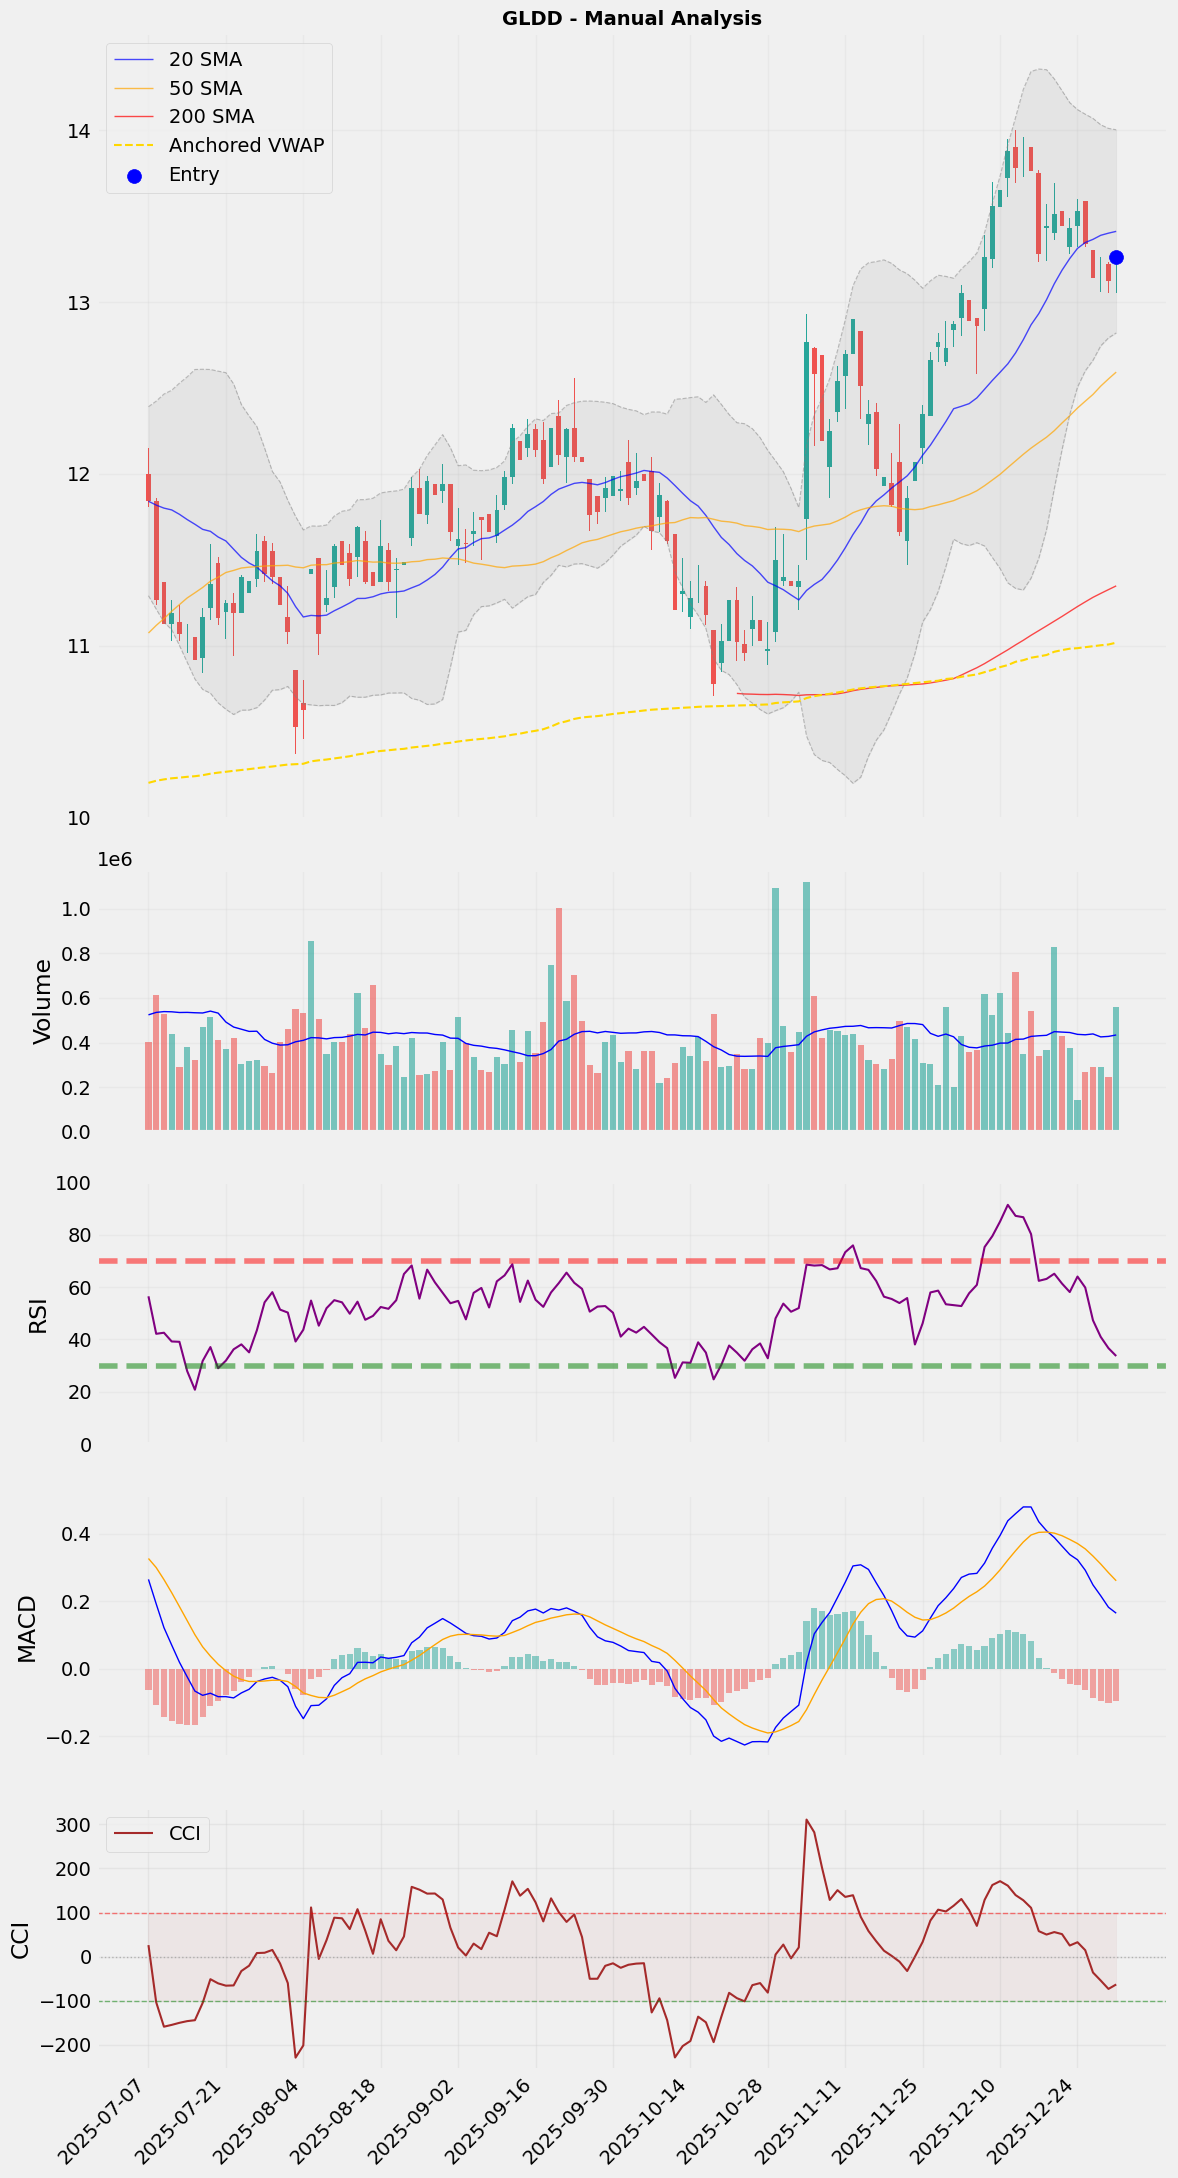

In [19]:
# --- Manual Charting ---
# Enter the ticker symbol you want to analyze
ticker_to_plot = 'GLDD'  # <--- Change this to your desired stock (e.g., 'NVDA', 'TSLA', 'SHOP.TO')

print(f"Generating chart for {ticker_to_plot}...")

# 1. Get Data
# Check if we already have the data from the scanner loop
if 'data_store' in locals() and ticker_to_plot in data_store:
    df_plot = data_store[ticker_to_plot]
    # Force re-calculation to ensure new indicators (like CCI) are present
    df_plot = calculate_indicators(df_plot)
else:
    # Download if not in memory
    print(f"Data not found in cache. Downloading {ticker_to_plot}...")
    data_dict = download_data([ticker_to_plot], START_DATE, END_DATE)
    if ticker_to_plot in data_dict:
        df_plot = calculate_indicators(data_dict[ticker_to_plot])
        # Apply strategies to see if any signals exist
        df_plot = apply_strategies(df_plot)
    else:
        df_plot = None
        print(f"Could not find data for {ticker_to_plot}")

# 2. Plot
if df_plot is not None and not df_plot.empty:
    # Check for active signals to display context
    latest_manual = df_plot.iloc[-1]
    manual_signal = "Manual Analysis"
    
    # Check if any strategy signals are active right now
    if 'Signal_Breakout' in df_plot.columns:
        if latest_manual['Signal_Breakout']: manual_signal = "Breakout (Active)"
        elif latest_manual['Signal_Pullback']: manual_signal = "Pullback (Active)"
        elif latest_manual['Signal_MeanRev']: manual_signal = "Mean Reversion (Active)"
    
    # Plot using the helper function
    # We pass the current close as the 'entry' for visualization purposes
    
    plot_candidate(
        ticker_to_plot, 
        df_plot, 
        signal_type=manual_signal,
        entry_price=latest_manual['Close'])
else:
    print("No data available to plot.")
